In [153]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.panel import PanelOLS, RandomEffects

import warnings

warnings.filterwarnings("ignore")

spain_epu_index_path = f"D:\Hangze Wu\BSE\DSDM\semester3\Master Thesis\github_thesis\deloitte_digital_banking\deloitte_digital_banking\data\\NEW_SPAIN_EPU_INDEX.xlsx"
spain_epu_indexn_data = pd.read_excel(spain_epu_index_path,skiprows= 1)


####################### date
spain_epu_indexn_data.rename(columns={'Index value':'spain_epu'},inplace=True)

spain_epu_indexn_data['date'] = pd.to_datetime(spain_epu_indexn_data['Year'].astype(str) + '-' + spain_epu_indexn_data['Month'].astype(str), format='%Y-%m')

# Drop the original 'Year' and 'Month' columns as they are no longer necessary
spain_epu_indexn_data = spain_epu_indexn_data.drop(['Year', 'Month'], axis=1)

spain_epu_indexn_data.head(3)

,spain_epu,date
0,31.018169,1997-01-01
1,50.695080,1997-02-01
2,43.754341,1997-03-01


In [154]:
regression_clean_data_path = f"D:\Hangze Wu\BSE\DSDM\semester3\Master Thesis\github_thesis\deloitte_digital_banking\deloitte_digital_banking\data\\regression_clean_data_final_1.csv"
regression_clean_data = pd.read_csv(regression_clean_data_path)

regression_clean_data['date'] = pd.to_datetime(regression_clean_data ['date'])

# Merge the dataframes on the 'date' column
merged_df = pd.merge(regression_clean_data , spain_epu_indexn_data, on='date', how='inner')

merged_df.head(3)

,bank,date,web_traffic,cross_visitation,search_interest,rank,incentive,apr,mentions,app_installs,ppc_spend,spain_epu
0,abanca,2021-12-01,15202.983835,0.077994,7.75,4.0,150.0,0.0,1.0,43605.699637,1506.110026,159.575287
1,abanca,2022-01-01,42183.913207,0.062500,7.80,4.0,150.0,0.0,1.0,43605.699637,1506.110026,124.229675
2,abanca,2022-02-01,34498.153115,0.052288,7.25,4.0,150.0,0.0,2.0,48647.434439,32750.639361,133.508606


In [155]:
merged_df.set_index(['bank', 'date'], inplace=True)
result_df = merged_df
regression_clean_data = result_df
regression_clean_data['Log_Web_Traffic'] = np.log1p(regression_clean_data['web_traffic'])
regression_clean_data['Log_incentive'] = np.log1p(regression_clean_data['incentive'])
regression_clean_data['Log_spain_epu'] = np.log1p(regression_clean_data['spain_epu'])
regression_clean_data['Log_ppc_spend'] = np.log1p(regression_clean_data['ppc_spend'])
regression_clean_data['Log_app_installs'] = np.log1p(regression_clean_data['app_installs'])


regression_clean_data['Log_apr'] = np.log1p(regression_clean_data['apr'])

#regression_clean_data['date'] = pd.to_datetime(regression_clean_data['date'])

# Set index for panel data
#regression_clean_data.set_index(['bank', 'date'], inplace=True)

# Sort the DataFrame by the index
#regression_clean_data.sort_index(inplace=True)

display(regression_clean_data.head(3))

# Check how many unique account products
unique_account_products = regression_clean_data.index.get_level_values('bank').nunique()
print(f"Number of unique account products: {unique_account_products}")

web_traffic  cross_visitation  search_interest  rank  \
bank   date                                                                
abanca 2021-12-01  15202.983835          0.077994             7.75   4.0   
       2022-01-01  42183.913207          0.062500             7.80   4.0   
       2022-02-01  34498.153115          0.052288             7.25   4.0   

                   incentive  apr  mentions  app_installs     ppc_spend  \
bank   date                                                               
abanca 2021-12-01      150.0  0.0       1.0  43605.699637   1506.110026   
       2022-01-01      150.0  0.0       1.0  43605.699637   1506.110026   
       2022-02-01      150.0  0.0       2.0  48647.434439  32750.639361   

                    spain_epu  Log_Web_Traffic  Log_incentive  Log_spain_epu  \
bank   date                                                                    
abanca 2021-12-01  159.575287         9.629313        5.01728       5.078763   
       2022-01-01  124.229675        10.649818        5.01728       4.830149   
       2022-02-01  133.508606        10.448690        5.01728       4.901628   

                   Log_ppc_spend  Log_app_installs  Log_apr  
bank   date                                                  
abanca 2021-12-01       7.317949         10.682966      0.0  
       2022-01-01       7.317949         10.682966      0.0  
       2022-02-01      10.396708         10.792375      0.0

Number of unique account products: 11


In [8]:
filtered_df = regression_clean_data

#### previous 2 Lag & 12 Month Dummies

In [156]:
filtered_df = regression_clean_data


import pandas as pd
# Ensure the DataFrame is sorted by 'bank' and 'date'
filtered_df = filtered_df.sort_index()

# Create lagged variables for past 1, 2, 3, and 4 months of web traffic
filtered_df['Log_Web_Traffic_Lag1'] = filtered_df.groupby(level='bank')['Log_Web_Traffic'].shift(1)
#filtered_df['Log_Web_Traffic_Lag2'] = filtered_df.groupby(level='bank')['Log_Web_Traffic'].shift(2)
#filtered_df['Log_Web_Traffic_Lag3'] = filtered_df.groupby(level='bank')['Log_Web_Traffic'].shift(3)
#filtered_df['Log_Web_Traffic_Lag4'] = filtered_df.groupby(level='bank')['Log_Web_Traffic'].shift(4)

# Drop rows with NaN values resulting from the lag operation
filtered_df = filtered_df.dropna()

# Check for duplicates
duplicates = filtered_df[filtered_df.index.duplicated()]

web_traffic_columns = filtered_df.filter(regex='(?i)web')
print("DataFrame with lagged variables:")
display(web_traffic_columns.head(3))

if not duplicates.empty:
    print("Duplicate entries found:")
    print(duplicates)
else:
    print("No duplicate entries found.")
    
# Extract month from the Date index and create dummy variables
filtered_df['Month'] = filtered_df.index.get_level_values('date').month
monthly_dummies = pd.get_dummies(filtered_df['Month'], prefix='Month', drop_first=False)

# Concatenate the dummy variables with the original DataFrame
filtered_df = pd.concat([filtered_df, monthly_dummies], axis=1)

print("DataFrame with monthly dummy variables:")

# Ensure the Month_9 column is numeric (if it contains True/False)
for month in ['Month_1','Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']:
    filtered_df[ month ] = filtered_df[ month ].astype(int)
    

# Filter columns that contain 'Month_'
month_columns = filtered_df.filter(like='Month_')
# Display the first 12 rows of these columns
display(month_columns.head(12))

final_df = filtered_df


DataFrame with lagged variables:


web_traffic  Log_Web_Traffic  Log_Web_Traffic_Lag1
bank   date                                                           
abanca 2022-01-01  42183.913207        10.649818              9.629313
       2022-02-01  34498.153115        10.448690             10.649818
       2022-03-01  34546.319021        10.450085             10.448690

No duplicate entries found.
DataFrame with monthly dummy variables:


Month_1  Month_2  Month_3  Month_4  Month_5  Month_6  \
bank   date                                                               
abanca 2022-01-01        1        0        0        0        0        0   
       2022-02-01        0        1        0        0        0        0   
       2022-03-01        0        0        1        0        0        0   
       2022-04-01        0        0        0        1        0        0   
       2022-05-01        0        0        0        0        1        0   
       2022-06-01        0        0        0        0        0        1   
       2022-07-01        0        0        0        0        0        0   
       2022-08-01        0        0        0        0        0        0   
       2022-09-01        0        0        0        0        0        0   
       2022-10-01        0        0        0        0        0        0   
       2022-11-01        0        0        0        0        0        0   
       2022-12-01        0        0        0        0        0        0   

                   Month_7  Month_8  Month_9  Month_10  Month_11  Month_12  
bank   date                                                                 
abanca 2022-01-01        0        0        0         0         0         0  
       2022-02-01        0        0        0         0         0         0  
       2022-03-01        0        0        0         0         0         0  
       2022-04-01        0        0        0         0         0         0  
       2022-05-01        0        0        0         0         0         0  
       2022-06-01        0        0        0         0         0         0  
       2022-07-01        1        0        0         0         0         0  
       2022-08-01        0        1        0         0         0         0  
       2022-09-01        0        0        1         0         0         0  
       2022-10-01        0        0        0         1         0         0  
       2022-11-01        0        0        0         0         1         0  
       2022-12-01        0        0        0         0         0         1

### Log on Web traffic
#### Remove outlier and sparse problem from large number.

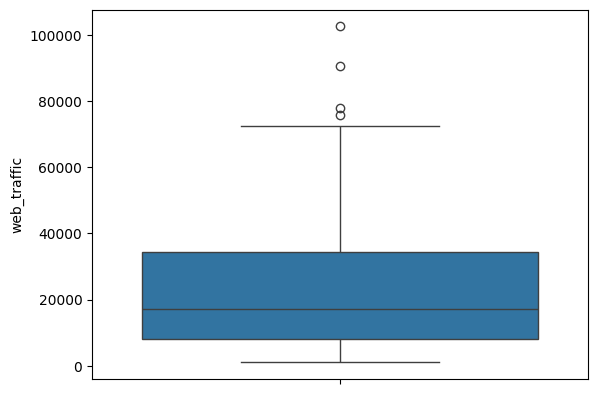

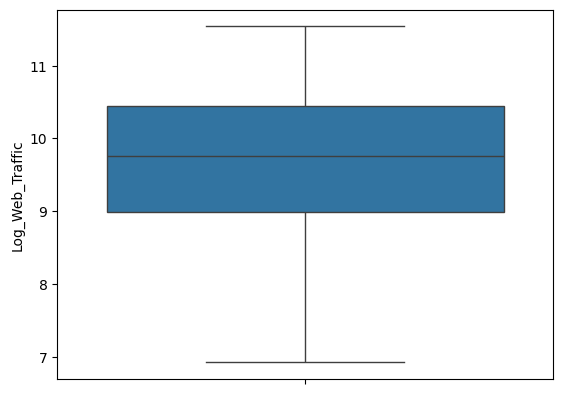

In [162]:
from scipy.stats import boxcox
import numpy as np

# Apply Box-Cox transformation
filtered_df['BoxCox_Web_Traffic'], _ = boxcox(filtered_df['web_traffic'])  # Adding 1 to avoid log(0)

### Check for Outlier
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize outliers
sns.boxplot(filtered_df['web_traffic'])
plt.show()


from scipy.stats import boxcox
import numpy as np

# Apply Box-Cox transformation
filtered_df['BoxCox_Web_Traffic'], _ = boxcox(filtered_df['Log_Web_Traffic'])

### Check for Outlier
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize outliers
sns.boxplot(filtered_df['Log_Web_Traffic'])
plt.show()



### ACF PACF , QQ plot

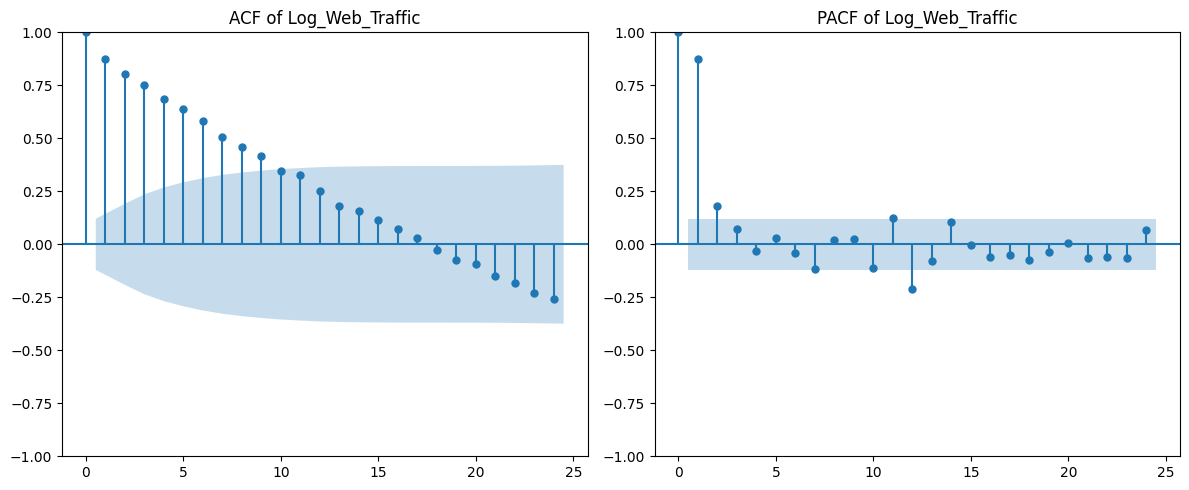

<Figure size 600x600 with 0 Axes>

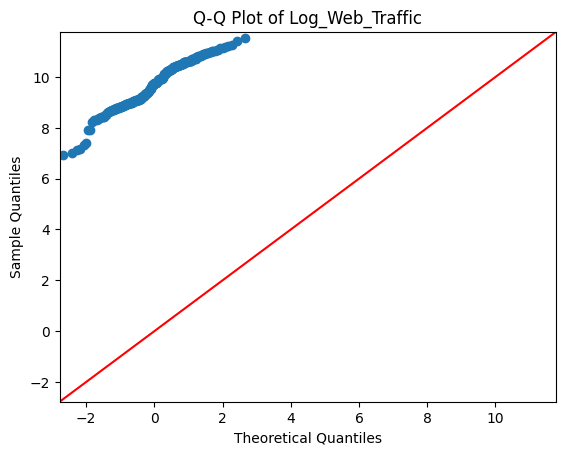

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Ensure all independent variables are numeric
numeric_columns = ['Log_Web_Traffic_Lag1']
filtered_df[numeric_columns] = filtered_df[numeric_columns].apply(pd.to_numeric, errors='coerce')


# Plotting ACF and PACF for Log_Web_Traffic
plt.figure(figsize=(12, 5))

# ACF plot
plt.subplot(1, 2, 1)
plot_acf(filtered_df['Log_Web_Traffic'], lags=24, ax=plt.gca())
plt.title('ACF of Log_Web_Traffic')

# PACF plot
plt.subplot(1, 2, 2)
plot_pacf(filtered_df['Log_Web_Traffic'], lags=24, ax=plt.gca(), method='ywm')
plt.title('PACF of Log_Web_Traffic')

plt.tight_layout()
plt.show()

# Q-Q plot
plt.figure(figsize=(6, 6))
sm.qqplot(filtered_df['Log_Web_Traffic'], line ='45')
plt.title('Q-Q Plot of Log_Web_Traffic')
plt.show()


#### Web Traffic
##### Although, we did log on large number to remove large value effect on distribution, in which could induce possible test statistic problems, the ACF and PACF plot shows that an AR(1) is a good start of fit with model.

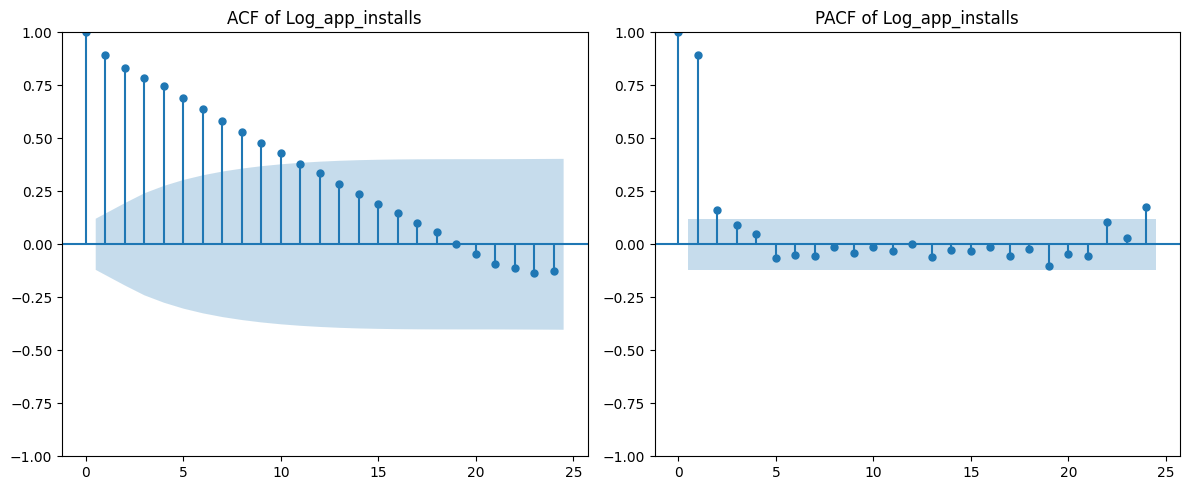

<Figure size 600x600 with 0 Axes>

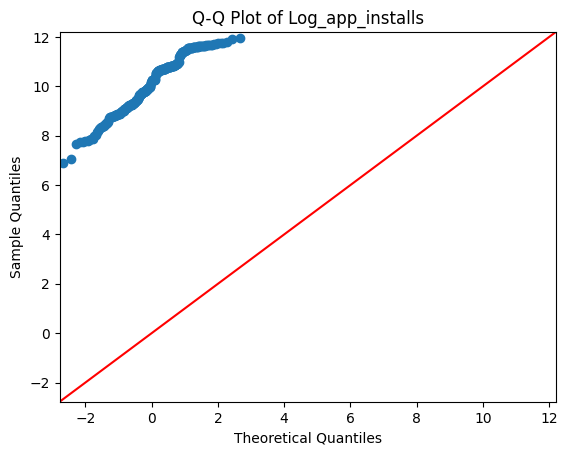

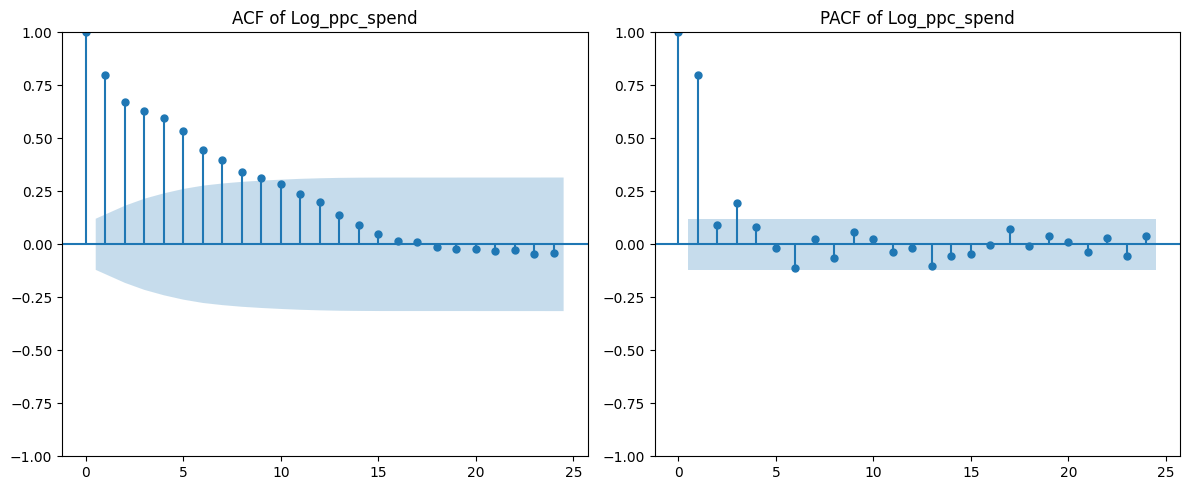

<Figure size 600x600 with 0 Axes>

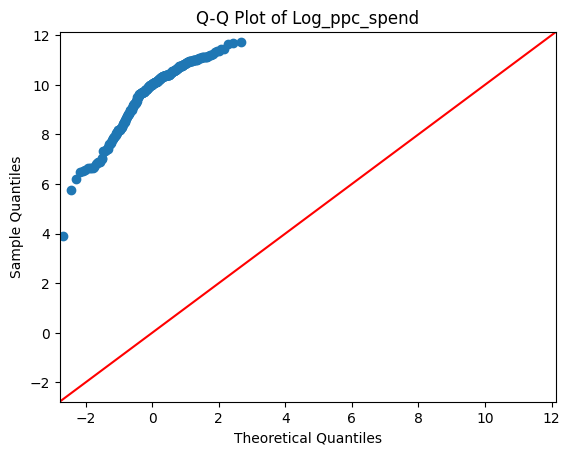

In [161]:
ind_vars = [#'cross_visitation',# 'apr',
       #'Log_incentive',#'mentions', 'rank', 'incentive',
        #'search_interest','spain_epu',#,'Log_spain_epu',
        'Log_app_installs','Log_ppc_spend']#,'app_installs','ppc_spend']

for ind in ind_vars:
    # Plotting ACF and PACF for Log_Web_Traffic
    plt.figure(figsize=(12, 5))

    # ACF plot
    plt.subplot(1, 2, 1)
    plot_acf(filtered_df[ind], lags=24, ax=plt.gca())
    plt.title(f'ACF of {ind}')

    # PACF plot
    plt.subplot(1, 2, 2)
    plot_pacf(filtered_df[ind], lags=24, ax=plt.gca(), method='ywm')
    plt.title(f'PACF of {ind}')

    plt.tight_layout()
    plt.show()

    # Q-Q plot
    plt.figure(figsize=(6, 6))
    sm.qqplot(filtered_df[ind], line ='45')
    plt.title(f'Q-Q Plot of {ind}')
    plt.show()



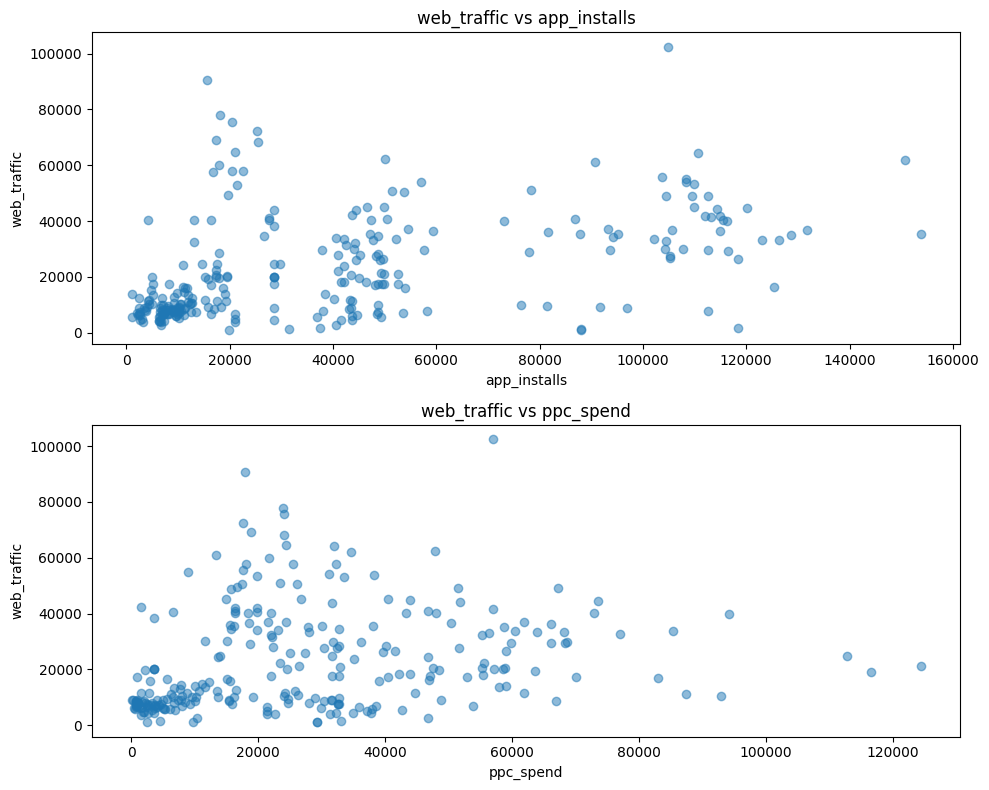

In [17]:
import matplotlib.pyplot as plt

# Extract the relevant columns
variables = filtered_df.columns.difference(['web_traffic'])
#num_vars = len(variables)
num_vars = 2

# Set up the subplot grid
fig, axes = plt.subplots(nrows=num_vars, ncols=1, figsize=(10, num_vars * 4))

index_of_var = 0
# Plot each variable against web_traffic
for i, var in enumerate(variables):
    if(var == 'ppc_spend' or var == 'app_installs'):
        ax = axes[index_of_var]
        ax.scatter( filtered_df[var], filtered_df['web_traffic'],alpha=0.5)
        ax.set_title(f'web_traffic vs {var}')
        ax.set_xlabel(var)
        ax.set_ylabel('web_traffic')

        index_of_var = index_of_var + 1

plt.tight_layout()
plt.show()


#### We find very high similarity distribution among bank features: ppc spending and number of app installs against with web traffic. This indicating high correlation between them.

# Causality Test

#### Granger test and Cross correlation function

# Granger Causality Test Explanation

The Granger causality test is based on the principle of forecasting one time series using past values of another time series. To perform this test, we use regression models to assess whether the inclusion of lagged values of one variable improves the prediction of another variable.

## Equations for Granger Causality Test

1. **Unrestricted Model**:
   This model includes lagged values of both the dependent variable $Y_t$ and the potential causative variable $X_t$.

   $$
   Y_t = \alpha_0 + \sum_{i=1}^{p} \alpha_i Y_{t-i} + \sum_{j=1}^{q} \beta_j X_{t-j} + \epsilon_t
   $$

   Where:
   - $Y_t$ is the dependent variable (e.g., `web_traffic`).
   - $X_t$ is the independent variable (e.g., `cross_visitation`).
   - $p$ is the number of lags for $Y_t$.
   - $q$ is the number of lags for $X_t$.
   - $\alpha_i$ and $\beta_j$ are coefficients.
   - $\epsilon_t$ is the error term.

2. **Restricted Model**:
   This model includes only lagged values of the dependent variable $Y_t$, excluding the potential causative variable $X_t$.

   $$
   Y_t = \alpha_0 + \sum_{i=1}^{p} \alpha_i Y_{t-i} + \eta_t
   $$

   Where:
   - $\eta_t$ is the error term of the restricted model.

## Hypothesis Testing

The Granger causality test involves testing the null hypothesis that the coefficients of the lagged $X_t$ terms are zero (i.e., $ \beta_1 = \beta_2 = \cdots = \beta_q = 0 $).

- **Null Hypothesis ($H_0$)**: $X_t$ does not Granger-cause $Y_t$.
- **Alternative Hypothesis ($H_1$)**: $X_t$ Granger-causes $Y_t$.

## F-Test for Granger Causality

To determine if the inclusion of the lagged values of $X_t$ provides significant explanatory power for $Y_t$, an F-test is used to compare the unrestricted and restricted models. The F-statistic is calculated as follows:

$$
F = \frac{ \left( \frac{RSS_{\text{restricted}} - RSS_{\text{unrestricted}}}{q} \right) }{ \left( \frac{RSS_{\text{unrestricted}}}{n - p - q - 1} \right) }
$$

Where:
- $RSS_{\text{restricted}}$ is the residual sum of squares of the restricted model.
- $RSS_{\text{unrestricted}}$ is the residual sum of squares of the unrestricted model.
- $q$ is the number of lagged $X_t$ terms.
- $n$ is the number of observations.
- $p$ is the number of lagged $Y_t$ terms.

The F-statistic follows an $F$-distribution with $q$ and $n - p - q - 1$ degrees of freedom. The p-value associated with the F-statistic is used to determine whether to reject the null hypothesis.

## Example Calculation

For a simple case with one lag ($q=1$):

1. **Unrestricted Model**: $Y_t = \alpha_0 + \alpha_1 Y_{t-1} + \beta_1 X_{t-1} + \epsilon_t$
2. **Restricted Model**: $Y_t = \alpha_0 + \alpha_1 Y_{t-1} + \eta_t$

Calculate the F-statistic based on the RSS of both models and compare it to the critical value from the F-distribution or use the p-value to decide on the null hypothesis.

## Interpretation

- If the p-value is less than the significance level (e.g., 0.05), reject the null hypothesis, indicating that $X_t$ Granger-causes $Y_t$.
- If the p-value is greater than the significance level, do not reject the null hypothesis, indicating that $X_t$ does not Granger-cause $Y_t$.

The Granger causality test is thus a way to evaluate the predictive causality between two time series.


### Average by date first and then test

In [55]:
['web_traffic','Log_Web_Traffic']+['cross_visitation', 'apr', 'mentions', 'rank', 'incentive', 'Log_incentive',
                   'search_interest', 'spain_epu', 'ppc_spend', 'Log_ppc_spend', 'app_installs', 'Log_app_installs']


model_columns = ['Log_Web_Traffic']+['cross_visitation', 'apr','Log_apr','mentions', 'rank','Log_incentive',
                   'search_interest', 'spain_epu','Log_ppc_spend','Log_app_installs']

In [152]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def check_stationarity(data, columns, max_diff=2):
    results = {}
    for column in columns:
        data = data.groupby('date').mean()
        series = data[column].dropna()  # Ensure no NaN values
        result = adfuller(series, autolag='AIC')  # Initial ADF test
        p_value = result[1]
        if p_value < 0.05:
            results[column] = ('Stationary without differencing', result[0], result[1])
        else:
            for d in range(1, max_diff+1):
                diff_series = series.diff(d).dropna()  # Differencing the series
                result = adfuller(diff_series, autolag='AIC')
                p_value = result[1]
                if p_value < 0.05:
                    results[column] = (f'Stationary after differencing {d} time(s)', result[0], result[1])
                    break
            if column not in results:
                results[column] = ('Not stationary even after max differencing', result[0], result[1])
    return results

# Assuming 'df' is your DataFrame
columns_to_test = ['web_traffic','Log_Web_Traffic']+['cross_visitation', 'apr', 'Log_apr', 'mentions', 'rank', 'incentive', 'Log_incentive',
                   'search_interest', 'spain_epu', 'ppc_spend', 'Log_ppc_spend', 'app_installs', 'Log_app_installs']
columns_to_test = model_columns
stationarity_results = check_stationarity(filtered_df, columns_to_test)

In [153]:
for variable, result in stationarity_results.items():
    print(f'{variable}: {result[0]}, ADF Statistic: {result[1]:.4f}, p-value: {result[2]:.4f}')


Log_Web_Traffic: Stationary without differencing, ADF Statistic: -3.1484, p-value: 0.0232
cross_visitation: Stationary after differencing 2 time(s), ADF Statistic: -5.7343, p-value: 0.0000
apr: Not stationary even after max differencing, ADF Statistic: -2.4332, p-value: 0.1326
Log_apr: Stationary after differencing 1 time(s), ADF Statistic: -6.1149, p-value: 0.0000
mentions: Stationary after differencing 1 time(s), ADF Statistic: -4.0287, p-value: 0.0013
rank: Stationary after differencing 1 time(s), ADF Statistic: -4.3567, p-value: 0.0004
Log_incentive: Stationary without differencing, ADF Statistic: -3.8006, p-value: 0.0029
search_interest: Stationary without differencing, ADF Statistic: -4.1573, p-value: 0.0008
spain_epu: Stationary without differencing, ADF Statistic: -4.4792, p-value: 0.0002
Log_ppc_spend: Stationary after differencing 1 time(s), ADF Statistic: -5.3364, p-value: 0.0000
Log_app_installs: Stationary after differencing 2 time(s), ADF Statistic: -124.4686, p-value: 0.

In [154]:
import pandas as pd

data = {
    "Variable": ["Log_Web_Traffic", "cross_visitation", "apr", "Log_apr", "mentions", "rank", "Log_incentive", "search_interest", "spain_epu", "Log_ppc_spend", "Log_app_installs"],
    "Stationarity after conversion": [
        "Stationary", 
        "Stationary", 
        "Not stationary", 
        "Stationary", 
        "Stationary", 
        "Stationary", 
        "Stationary", 
        "Stationary", 
        "Stationary", 
        "Stationary", 
        "Stationary"
    ],
    "Transformation": [
        "without", 
        "differencing 2", 
        "Not stationary after differencing 3", 
        "differencing 1", 
        "differencing 1", 
        "differencing 1", 
        "without", 
        "without", 
        "without", 
        "differencing 1", 
        "differencing 2"
    ],
    "ADF Statistic": [-3.1484, -5.7343, -2.4332, -6.1149, -4.0287, -4.3567, -3.8006, -4.1573, -4.4792, -5.3364, -124.4686],
    "p-value": [0.0232, 0.0000, 0.1326, 0.0000, 0.0013, 0.0004, 0.0029, 0.0008, 0.0002, 0.0000, 0.0000]
}

stationary_df = pd.DataFrame(data)
display(stationary_df)


,Variable,Stationarity after conversion,Transformation,ADF Statistic,p-value
0,Log_Web_Traffic,Stationary,without,-3.1484,0.0232
1,cross_visitation,Stationary,differencing 2,-5.7343,0.0000
2,apr,Not stationary,Not stationary after differencing 3,-2.4332,0.1326
3,Log_apr,Stationary,differencing 1,-6.1149,0.0000
4,mentions,Stationary,differencing 1,-4.0287,0.0013
5,rank,Stationary,differencing 1,-4.3567,0.0004
6,Log_incentive,Stationary,without,-3.8006,0.0029
7,search_interest,Stationary,without,-4.1573,0.0008
8,spain_epu,Stationary,without,-4.4792,0.0002
9,Log_ppc_spend,Stationary,differencing 1,-5.3364,0.0000


### Stationary compute

In [136]:
from statsmodels.tsa.stattools import grangercausalitytests
import pandas as pd

# Define maximum number of lags to test for causality
max_lag = 6

# List of variables of interest
interest_columns = ['cross_visitation', 'Log_apr', 'mentions',  'Log_incentive',
                    'search_interest', 'spain_epu', 'Log_ppc_spend', 'Log_app_installs'] #'apr','rank',

# Initialize an empty dictionary to store results
results_dict = {}

# Loop over each column to perform the Granger causality test
for column in interest_columns:
        test_column = column + '_diff' if (column + '_diff') in df.columns else column + '_diff2' if (column + '_diff2') in df.columns else column 
        print(test_column)

        if test_column != 'rank_diff' or test_column != 'apr_diff':
            temp_df = df[['Log_Web_Traffic', test_column]].dropna()

            # Check and print the number of observations
            print(f"Testing causality from {test_column} to Log_Web_Traffic with {len(temp_df)} observations.")
            
            if len(temp_df) > max_lag:  # Only perform the test if there are enough observations
                results = grangercausalitytests(temp_df, maxlag=max_lag, verbose=False)
                # Extracting and storing chi-squared test p-values
                results_dict[test_column] = {f"Lag {lag}": result[0]['ssr_chi2test'][1] for lag, result in results.items()}
            else:
                print(f"Not enough data to test {test_column} up to {max_lag} lags.")
                results_dict[test_column] = {f"Lag {i+1}": None for i in range(max_lag)}  # Store None for insufficient data
        else:
            None

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results_dict)
results_df.index.name = "Number of Lags"

# Display the DataFrame
display(results_df)

cross_visitation_diff2
Testing causality from cross_visitation_diff2 to Log_Web_Traffic with 22 observations.
Log_apr_diff
Testing causality from Log_apr_diff to Log_Web_Traffic with 22 observations.
mentions_diff
Testing causality from mentions_diff to Log_Web_Traffic with 22 observations.
Log_incentive
Testing causality from Log_incentive to Log_Web_Traffic with 22 observations.
search_interest
Testing causality from search_interest to Log_Web_Traffic with 22 observations.
spain_epu
Testing causality from spain_epu to Log_Web_Traffic with 22 observations.
Log_ppc_spend_diff
Testing causality from Log_ppc_spend_diff to Log_Web_Traffic with 22 observations.
Log_app_installs_diff2
Testing causality from Log_app_installs_diff2 to Log_Web_Traffic with 22 observations.


,cross_visitation_diff2,Log_apr_diff,mentions_diff,Log_incentive,search_interest,spain_epu,Log_ppc_spend_diff,Log_app_installs_diff2
Number of Lags,,,,,,,,
Lag 1,0.733502,9.134711e-01,5.888620e-01,0.053826,5.848240e-01,0.403188,0.068536,3.038991e-01
Lag 2,0.933549,8.207583e-01,5.653181e-01,0.208133,1.356021e-01,0.190301,0.000344,3.526375e-02
Lag 3,0.135531,1.150594e-01,6.373605e-02,0.219548,8.111212e-02,0.213874,0.105075,7.482105e-02
Lag 4,0.011181,2.175953e-03,3.304985e-02,0.154545,8.496528e-01,0.368684,0.229699,2.585330e-03
Lag 5,0.050299,4.193535e-02,1.014597e-03,0.000002,5.704092e-02,0.000057,0.000155,3.606626e-09
Lag 6,0.015667,1.061761e-08,5.370216e-07,0.000003,2.337823e-35,0.000406,0.000019,1.237633e-31


### heatmap for calculated p value

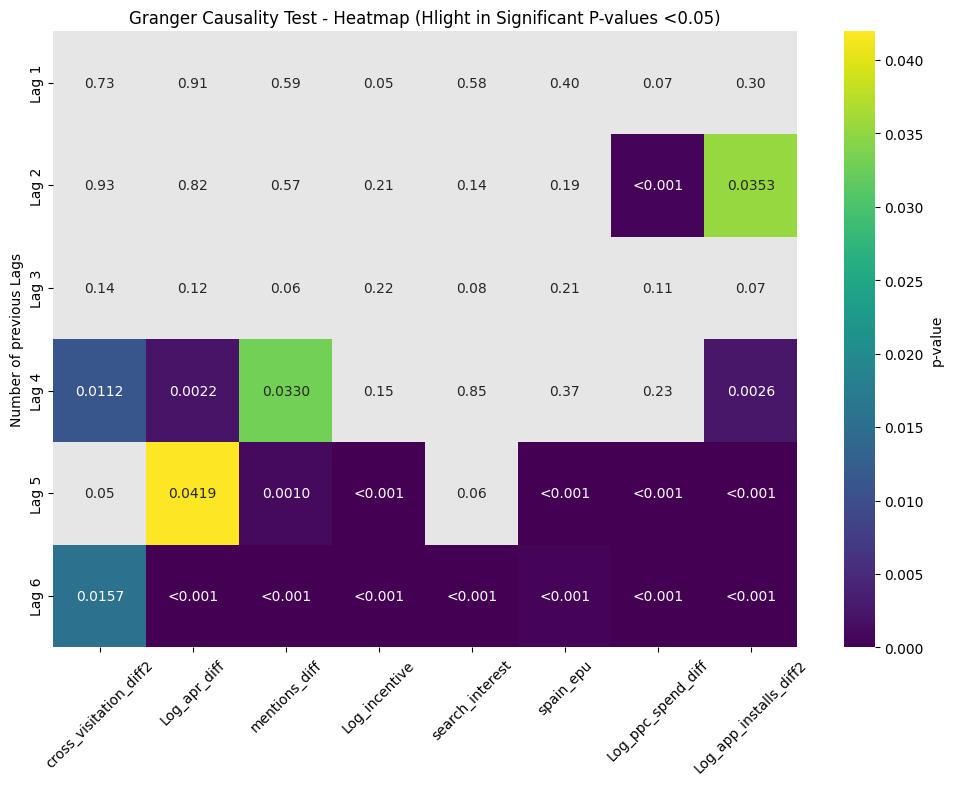

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = results_df  # p value df

# Define the color map
cmap = sns.color_palette("viridis", as_cmap=True)

# Mask for significant p-values
p_value_threshold = 0.05
significant_mask = df < p_value_threshold

# Apply a function to format the p-values for display
def format_p_value(val):
    if val < 0.001:
        return "<0.001"
    elif val < 0.05:
        return f"{val:.4f}"
    else:
        return f"{val:.2f}"  # Format non-significant p-values to 2 decimal places

# Use the DataFrame's applymap method to apply formatting to each element
formatted_df = df.applymap(format_p_value)

# Plotting
plt.figure(figsize=(12, 8))

# Plot non-significant p-values with a light color
sns.heatmap(df, annot=formatted_df, mask=significant_mask, cmap=[(0.9, 0.9, 0.9)], cbar=False, fmt="")

# Overlay significant p-values with 'viridis' color map
sns.heatmap(df, annot=formatted_df, mask=~significant_mask, cmap=cmap, cbar_kws={'label': 'p-value'}, fmt="")

plt.title('Granger Causality Test - Heatmap (Hlight in Significant P-values <0.05)')
plt.xticks(rotation = 45)
plt.ylabel('Number of previous Lags')
plt.show()


In [40]:
series=df['apr'].groupby('date').mean()

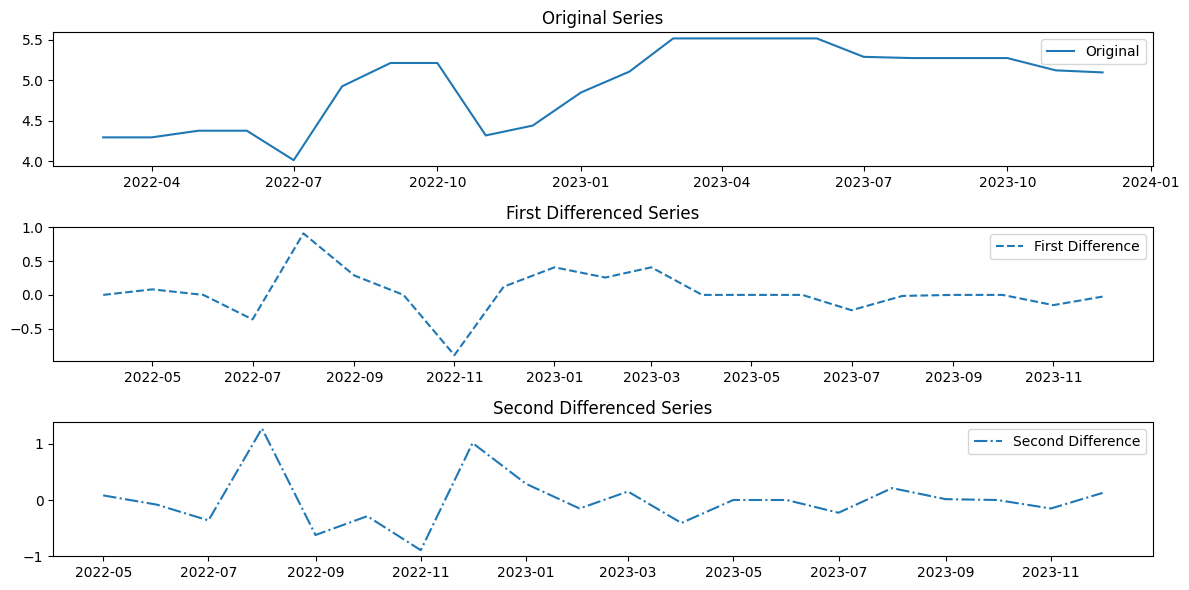

In [41]:
plt.figure(figsize=(12, 6))
plt.subplot(311)
plt.plot(series, label='Original')
plt.title('Original Series')
plt.legend()

plt.subplot(312)
plt.plot(series.diff(), label='First Difference', linestyle='--')
plt.title('First Differenced Series')
plt.legend()

plt.subplot(313)
plt.plot(series.diff().diff(), label='Second Difference', linestyle='-.')
plt.title('Second Differenced Series')
plt.legend()

plt.tight_layout()
plt.show()


## Spearman Rank Correlation

### Principle
Spearman's rank correlation coefficient $\rho$ or $r_s$ measures the strength and direction of the association between two ranked variables. Unlike Pearson's correlation, which measures linear relationships, Spearman's correlation assesses how well the relationship between two variables can be described using a monotonic function.

### Equation
1. **Rank the Data**:
   - Convert the raw data values into ranks.
   - If there are ties (equal values), assign to each tied value the average of the ranks that would have been assigned without ties.

2. **Difference in Ranks**:
   - For each pair of observations, calculate the difference between the ranks: $d_i = \text{rank}(X_i) - \text{rank}(Y_i)$.

3. **Spearman's Rank Correlation Coefficient**:
   $$
   \rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}
   $$
   where:
   - $d_i$ is the difference between the ranks of corresponding values of $X$ and $Y$,
   - $n$ is the number of observations.


## Overall Entities

In [156]:
import scipy.stats as stats

# Calculate Spearman rank correlation coefficients
spearman_correlations = filtered_df.corr(method='spearman')

# Display Spearman correlation of all variables with 'web_traffic'
print(spearman_correlations['web_traffic'])


web_traffic                1.000000
cross_visitation           0.512196
search_interest            0.469039
rank                      -0.291536
incentive                  0.380830
apr                       -0.261143
mentions                   0.026538
app_installs               0.522670
ppc_spend                  0.385025
spain_epu                 -0.031906
number_of_employee         0.565600
assets_under_management    0.597357
number_of_branches         0.723167
age                        0.648705
has_stores                 0.549064
founded_before_2000        0.469256
Log_Web_Traffic            1.000000
Log_incentive              0.380830
Log_spain_epu             -0.031906
Log_ppc_spend              0.385025
Log_app_installs           0.522670
Log_apr                   -0.261143
Log_Web_Traffic_Lag1       0.914409
Month                      0.033354
Month_1                    0.001439
Month_2                   -0.020321
Month_3                   -0.000540
Month_4                   -0

## Average score across banks

In [25]:
import pandas as pd

# Compute Spearman Rank Correlation for each bank and average them
spearman_correlations = []

# Group by 'bank' and compute Spearman Rank correlation for each group
for bank, group in filtered_df.groupby('bank'):
    spearman_corr = group.corr(method='spearman')
    spearman_correlations.append(spearman_corr['web_traffic'])

# Convert list of correlations to DataFrame
spearman_correlations_df = pd.DataFrame(spearman_correlations)

# Compute the average correlation across banks
average_spearman_correlation = spearman_correlations_df.mean()
print("Average Spearman Rank Correlation by Bank:")
print(average_spearman_correlation)


Average Spearman Rank Correlation by Bank:
web_traffic                1.000000
cross_visitation           0.222616
search_interest            0.014157
rank                       0.096112
incentive                  0.285228
apr                        0.148506
mentions                  -0.014833
app_installs               0.293711
ppc_spend                  0.088608
spain_epu                 -0.042009
number_of_employee              NaN
assets_under_management         NaN
number_of_branches              NaN
age                             NaN
has_stores                      NaN
founded_before_2000             NaN
Log_Web_Traffic            1.000000
Log_incentive              0.285228
Log_spain_epu             -0.042009
Log_ppc_spend              0.088608
Log_app_installs           0.293711
Log_Web_Traffic_Lag1       0.500518
Month                      0.086883
Month_1                    0.008003
Month_2                   -0.055458
Month_3                   -0.017746
Month_4              

## Cross-Correlation Function (CCF)

### Principle
The Cross-Correlation Function (CCF) measures the similarity between two time series as a function of the time lag applied to one of them. It helps in identifying any lead-lag relationships between the series.

### Equation
1. **Mean of the Series**:
   - Calculate the mean of each time series:
     $$
     \bar{X} = \frac{1}{T} \sum_{t=1}^T X_t
     $$
     $$
     \bar{Y} = \frac{1}{T} \sum_{t=1}^T Y_t
     $$

2. **Cross-Covariance**:
   - For a given lag $k$, calculate the cross-covariance:
     $$
     \gamma_{XY}(k) = \frac{1}{T} \sum_{t=1}^{T-k} (X_{t+k} - \bar{X})(Y_t - \bar{Y}) \quad \text{for } k \geq 0
     $$
     $$
     \gamma_{XY}(k) = \frac{1}{T} \sum_{t=1}^{T+k} (X_t - \bar{X})(Y_{t+k} - \bar{Y}) \quad \text{for } k < 0
     $$

3. **Cross-Correlation**:
   - Normalize the cross-covariance by the product of the standard deviations of $X$ and $Y$:
     $$
     \rho_{XY}(k) = \frac{\gamma_{XY}(k)}{\sigma_X \sigma_Y}
     $$
     where:
     - $\sigma_X$ and $\sigma_Y$ are the standard deviations of $X$ and $Y$, respectively.


### Average by date

apr Not stationary after differencing 3
Overall model p-values from Granger causality test:
      Log_apr_diff mentions_diff Log_incentive search_interest spain_epu  \
Lag 1     0.913471      0.588862      0.053826        0.939939  0.403188   
Lag 2     0.820758      0.565318      0.208133        0.464745  0.190301   
Lag 3     0.115059      0.063736      0.219548        0.444574  0.213874   
Lag 4     0.002176       0.03305      0.154545        0.264443  0.368684   
Lag 5     0.041935      0.001015      0.000002        0.012164  0.000057   
Lag 6          0.0      0.000001      0.000003        0.188585  0.000406   

      Log_ppc_spend_diff Log_app_installs_diff2  
Lag 1           0.855514               0.778568  
Lag 2            0.11265               0.583548  
Lag 3           0.000133               0.046867  
Lag 4           0.142458               0.143698  
Lag 5           0.445822               0.000001  
Lag 6           0.269911               0.000188  

Model Validation for Log

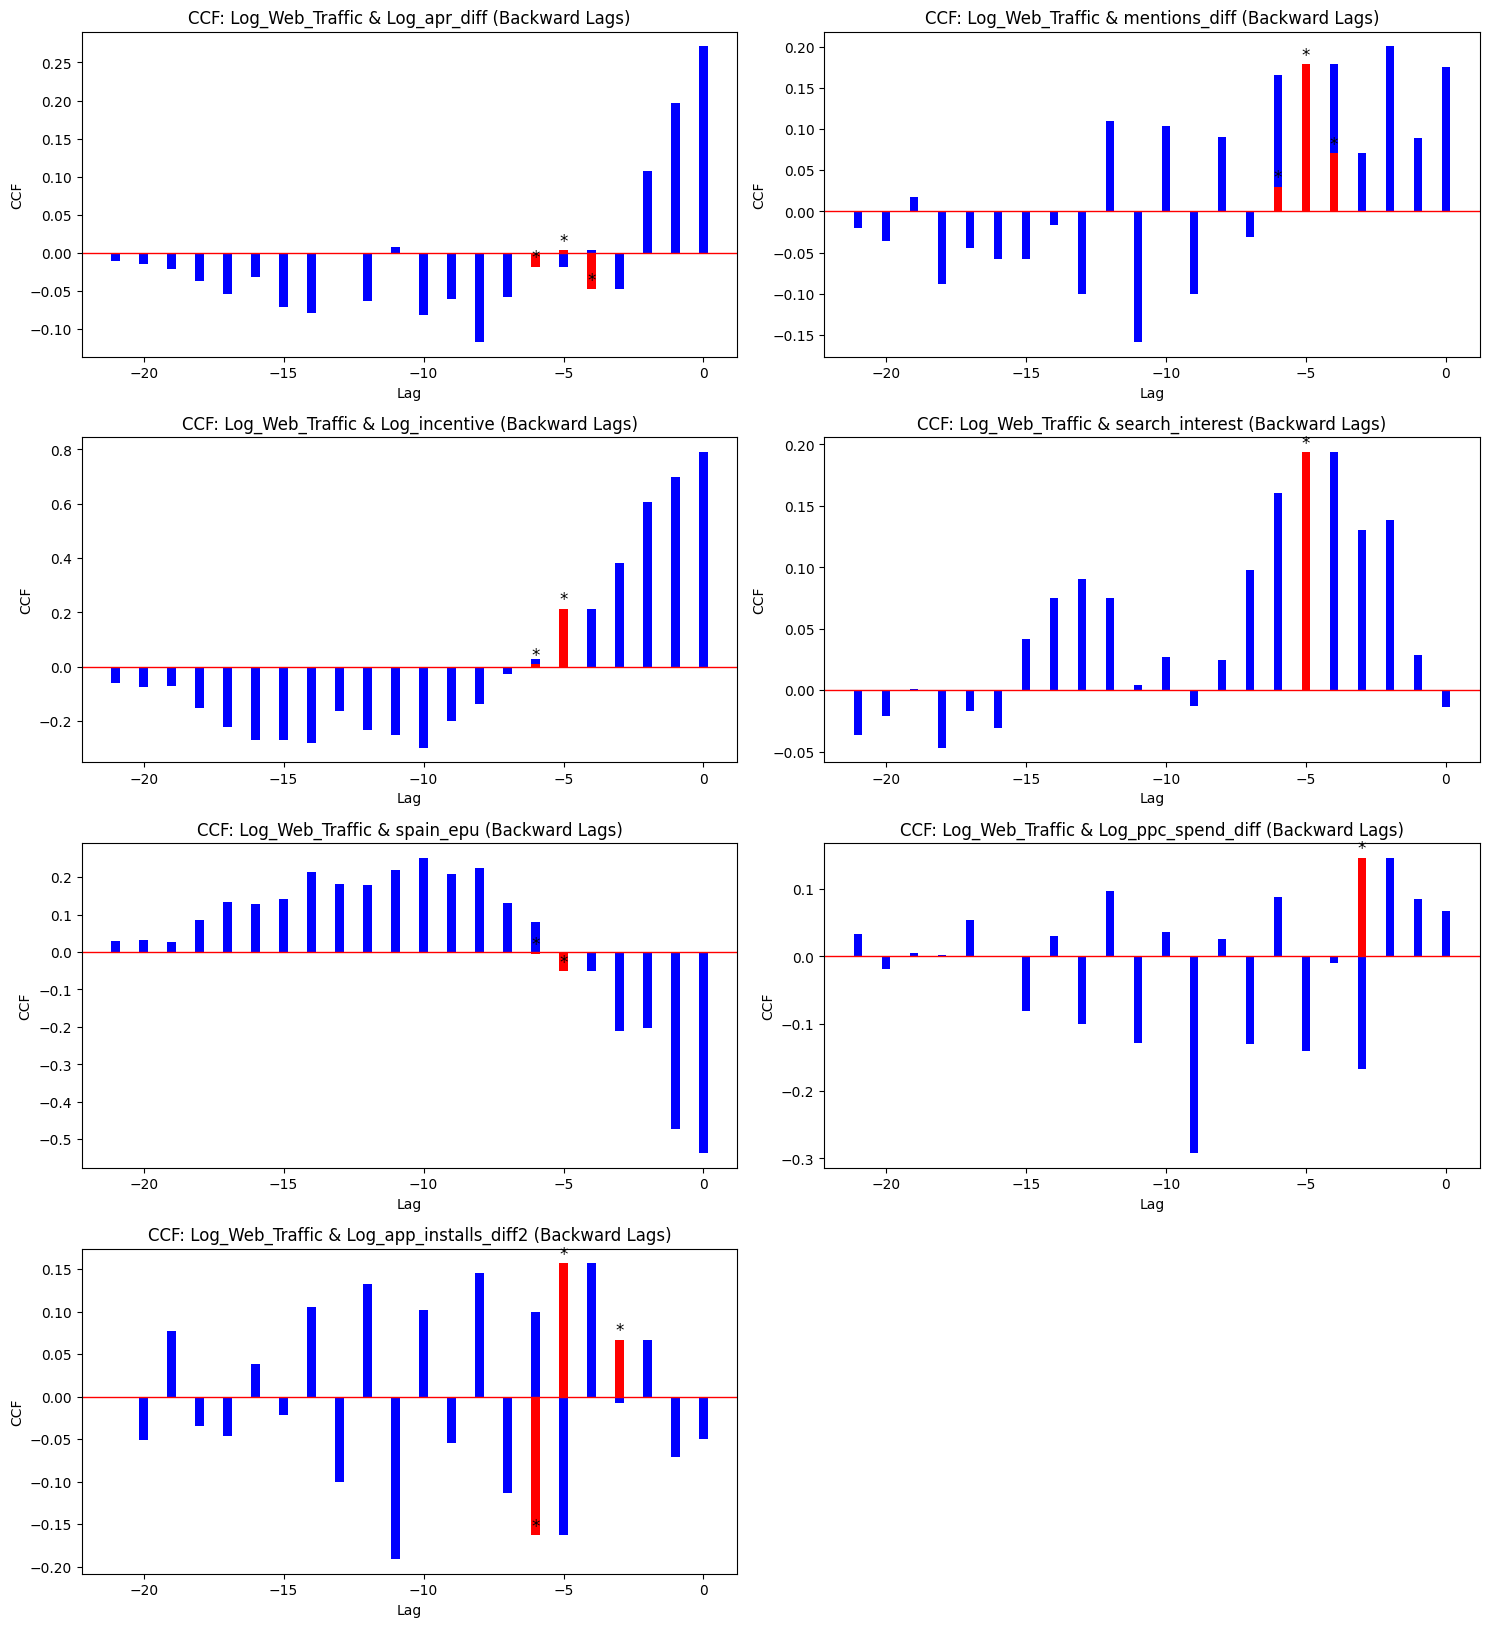

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import normaltest

############################################## Stationary Conversion ########################################################
transformations = {
    'Log_Web_Traffic': 'without',
    'cross_visitation': 'differencing 2',
    'apr': 'Not stationary after differencing 3',
    'Log_apr': 'differencing 1',
    'mentions': 'differencing 1',
    'rank': 'differencing 1',
    'Log_incentive': 'without',
    'search_interest': 'without',
    'spain_epu': 'without',
    'Log_ppc_spend': 'differencing 1',
    'Log_app_installs': 'differencing 2'
}

df = filtered_df.copy()
df = df.groupby('date').mean()

for column, transformation in transformations.items():
    if column in df.columns:
        if transformation == 'differencing 1':
            df[column + '_diff'] = df[column].diff()
        elif transformation == 'differencing 2':
            df[column + '_diff2'] = df[column].diff().diff()
        elif transformation == 'Not stationary after differencing 3':
            print(f'{column} Not stationary after differencing 3')

# Drop rows with NaN values in the transformed columns
df.dropna(inplace=True)
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import normaltest

############################################## Stationary Conversion ########################################################

################################################ Cross Correlation Function ####################################################
stationary_columns = [
    'Log_apr_diff', 'mentions_diff', 
    'Log_incentive', 'search_interest', 'spain_epu', 
    'Log_ppc_spend_diff', 'Log_app_installs_diff2'
]


# Perform Granger causality test for a range of lags
max_lag = 6
granger_results = {}
for col in stationary_columns:
    try:
        granger_results[col] = sm.tsa.stattools.grangercausalitytests(df[['Log_Web_Traffic', col]], max_lag, verbose=False)
    except ValueError as e:
        print(f"Error performing Granger causality test for {col}: {e}")

# Extract p-values for overall chi-square test for each lag
chi_square_p_values = pd.DataFrame(index=[f'Lag {i}' for i in range(1, max_lag + 1)], columns=stationary_columns)
for column, result in granger_results.items():
    for lag in range(1, max_lag + 1):
        if lag in result:
            chi_square_p_values.loc[f'Lag {lag}', column] = result[lag][0]['ssr_chi2test'][1]

print("Overall model p-values from Granger causality test:")
print(chi_square_p_values)

# Function to validate model residuals
def model_validation(residuals):
    # Durbin-Watson statistic
    dw_stat = durbin_watson(residuals)
    print("Durbin-Watson statistic:", dw_stat)

    # ADF Test on residuals
    adf_test = adfuller(residuals)
    print("ADF Test on Residuals:")
    print(f"ADF Statistic: {adf_test[0]:.2f}")
    print(f"p-value: {adf_test[1]:.4f}")
    for key, value in adf_test[4].items():
        print(f'Critical Values {key}: {value:.2f}')

# Validate model residuals
for col in stationary_columns:
    model = sm.OLS(df['Log_Web_Traffic'], sm.add_constant(df[col])).fit()
    residuals = model.resid
    print(f"\nModel Validation for {col}:")
    model_validation(residuals)

# Plot Cross-Correlation Function (CCF) with significant lags highlighted
plt.figure(figsize=(15, 20))
for i, column in enumerate(stationary_columns):
    plt.subplot(5, 2, i + 1)
    ccf = sm.tsa.stattools.ccf(df['Log_Web_Traffic'], df[column], adjusted=False)
    lags = np.arange(-len(ccf) + 1, 1)
    ccf = ccf[::-1]

    # Plot CCF with wider bars
    bar_width = 0.3  # Adjust this value to change the bar width
    plt.bar(lags, ccf, width=bar_width, color='blue')

    # Highlight significant lags from chi-square test
    for lag in range(1, max_lag + 1):
        if not chi_square_p_values.empty and column in chi_square_p_values.columns:
            p_value = chi_square_p_values.loc[f'Lag {lag}', column]
            if p_value is not None and p_value < 0.05:
                plt.bar(-lag, ccf[-lag], width=bar_width, color='red')
                plt.text(-lag, ccf[-lag], '*', color='black', ha='center', va='bottom', fontsize=12)

    plt.title(f'CCF: Log_Web_Traffic & {column} (Backward Lags)')
    plt.xlabel('Lag')
    plt.ylabel('CCF')
    plt.axhline(0, color='red', linewidth=1)
plt.tight_layout()
plt.show()

### Model initail setup, Fixed effect: 
#### Test with remove time dependence by adding Log_web_traffic t-1, Robust error implementation

### Fixed Effect

In [31]:
ind_vars = ['apr', 'mentions', 'Log_incentive']#'cross_visitation', 'search_interest','rank',
    #('web_traffic', 'ppc_spend'),
    #('web_traffic', 'Log_ppc_spend'),
    #('web_traffic', 'app_installs'),
    #('web_traffic', 'Log_app_installs')

# Define the dependent variable and independent variables
y = filtered_df['Log_Web_Traffic']
#X = filtered_df[['google trend','Web Traffic_Lag1' ] + monthly_dummies.columns.tolist()]
#X = filtered_df[ind_vars+ ['Log_Web_Traffic_Lag1', 'Month_9']]
X = filtered_df[['Log_Web_Traffic_Lag1']]#'Log_Web_Traffic_Lag2']]#,'Log_Web_Traffic_Lag3']]#,'Log_Web_Traffic_Lag4']]

# Add a constant term to the model
X = sm.add_constant(X)

# Fit the fixed effects model with entity effects (account product effects)
mod = PanelOLS(y, X, entity_effects=True, drop_absorbed=True)
res = mod.fit()

# Display the results
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:        Log_Web_Traffic   R-squared:                        0.3971
Estimator:                   PanelOLS   R-squared (Between):              0.8582
No. Observations:                 264   R-squared (Within):               0.3971
Date:                Fri, Jun 28 2024   R-squared (Overall):              0.7622
Time:                        00:16:12   Log-likelihood                   -70.228
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      165.96
Entities:                          11   P-value                           0.0000
Avg Obs:                       24.000   Distribution:                   F(1,252)
Min Obs:                       24.000                                           
Max Obs:                       24.000   F-statistic (robust):             165.96
                            

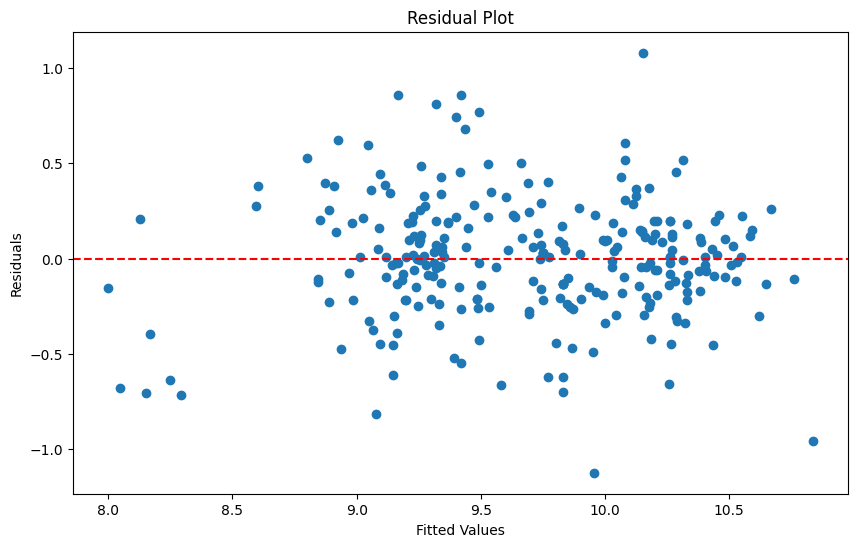

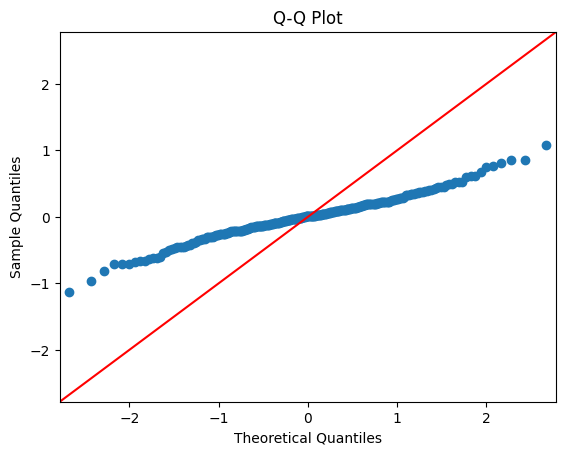

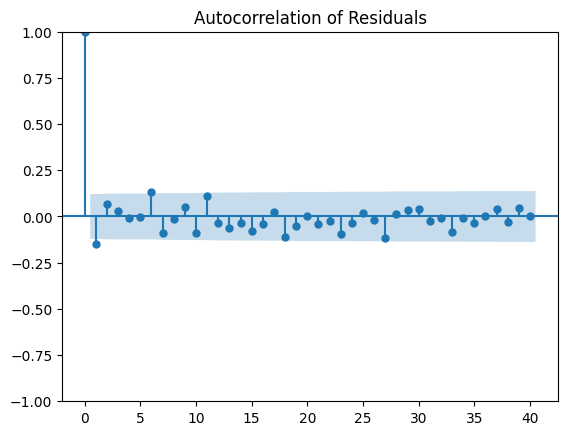

In [30]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Residual plot
residuals = res.resids
plt.figure(figsize=(10, 6))
plt.scatter(res.fitted_values, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Q-Q Plot
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot')
plt.show()

# Autocorrelation of Residuals
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title('Autocorrelation of Residuals')
plt.show()


##### Fitted value is predicted value of dependent varibale 'web traffic'. It shows that, around 10,000 and 15,000 has highest predicted power that has smallest errors. 


##### By adding 1 previous time dependency reflect acceptable error stationaru, by observing from ACF of erros.

# Model Validation Construction

In [46]:
ind_vars = ['apr', 'mentions', 'Log_incentive', #'cross_visitation', 'search_interest','rank',
            'Log_ppc_spend','Log_app_installs']
    #('web_traffic', 'ppc_spend'),
    #('web_traffic', 'Log_ppc_spend'),
    #('web_traffic', 'app_installs'),
    #('web_traffic', 'Log_app_installs')

# Define the dependent variable and independent variables
y = filtered_df['Log_Web_Traffic']
#X = filtered_df[['google trend','Web Traffic_Lag1' ] + monthly_dummies.columns.tolist()]
time_series_vars =  ['Log_Web_Traffic_Lag1']#,'Log_Web_Traffic_Lag2']#,'Log_Web_Traffic_Lag3']#,'Log_Web_Traffic_Lag4']
seasonal_vars = ['Month_1']#,'Month_9']
X = filtered_df[time_series_vars + ind_vars + seasonal_vars]

# Add a constant term to the model
X = sm.add_constant(X)

# Fit the fixed effects model with entity effects (account product effects)
mod = PanelOLS(y, X, entity_effects=True, drop_absorbed=True)
res = mod.fit()

# Display the results
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:        Log_Web_Traffic   R-squared:                        0.4232
Estimator:                   PanelOLS   R-squared (Between):              0.8524
No. Observations:                 264   R-squared (Within):               0.4232
Date:                Fri, Jun 28 2024   R-squared (Overall):              0.7630
Time:                        00:23:56   Log-likelihood                   -64.389
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      25.780
Entities:                          11   P-value                           0.0000
Avg Obs:                       24.000   Distribution:                   F(7,246)
Min Obs:                       24.000                                           
Max Obs:                       24.000   F-statistic (robust):             25.780
                            

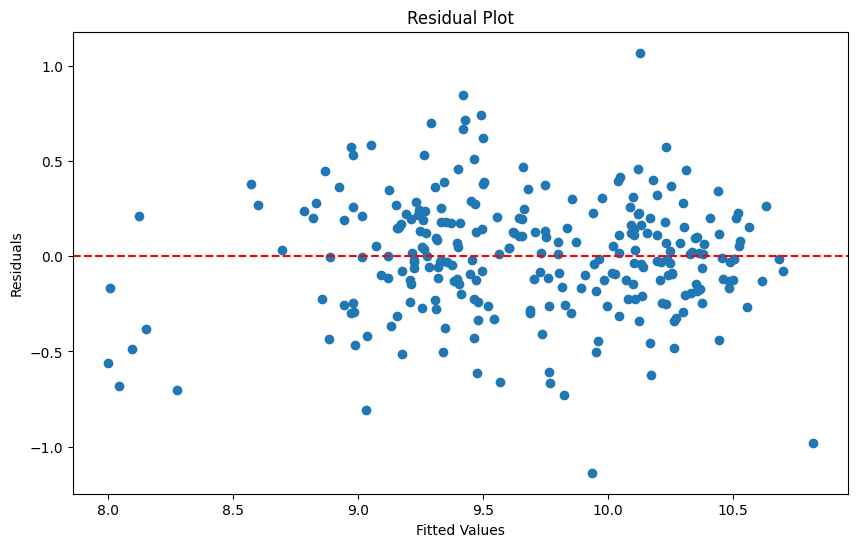

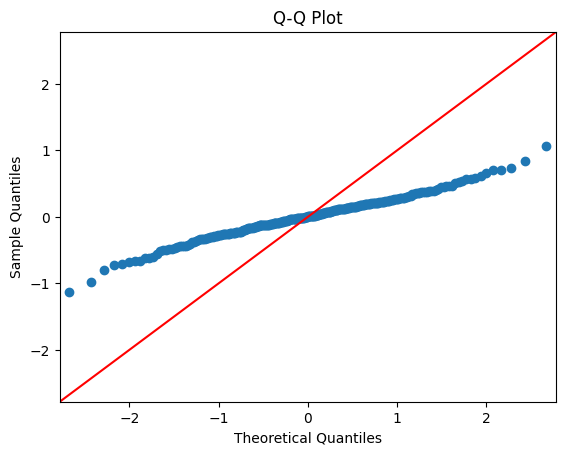

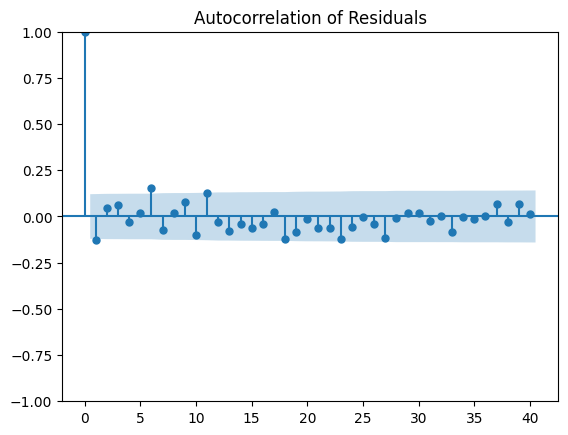

In [47]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Residual plot
residuals = res.resids
plt.figure(figsize=(10, 6))
plt.scatter(res.fitted_values, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Q-Q Plot
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot')
plt.show()

# Autocorrelation of Residuals
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title('Autocorrelation of Residuals')
plt.show()


## test autocorrelation

In [48]:
from linearmodels.panel import compare
from statsmodels.stats.stattools import durbin_watson

# Check for serial correlation in the residuals
dw_stat = durbin_watson(res.resids)

# Display Durbin-Watson statistic (values near 2 suggest no autocorrelation)
print("Durbin-Watson statistic:", dw_stat)


Durbin-Watson statistic: 2.2416881408163434


In [49]:
# Extract the DataFrame from PanelData
exog_df = res.model.exog.dataframe

# Display the DataFrame to confirm its structure
print(exog_df.head())

from statsmodels.stats.diagnostic import het_breuschpagan
import numpy as np

# Since we need residuals and the exogenous variables:
# Get residuals
residuals = res.resids

# Ensure residuals are in a compatible format (1D array)
if not isinstance(residuals, np.ndarray):
    residuals = np.array(residuals)

# Run the Breusch-Pagan test
bp_test = het_breuschpagan(residuals, exog_df)

# Print the test results
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_results = dict(zip(labels, bp_test))
print(bp_results)

# Optionally, confirm the columns just to make sure
print(exog_df.columns)


                   const  Log_Web_Traffic_Lag1  apr  mentions  Log_incentive  \
bank   date                                                                    
abanca 2022-01-01    1.0              9.629313  0.0       1.0        5.01728   
       2022-02-01    1.0             10.649818  0.0       2.0        5.01728   
       2022-03-01    1.0             10.448690  0.0       2.0        5.01728   
       2022-04-01    1.0             10.450085  0.0       2.0        5.70711   
       2022-05-01    1.0             10.609287  0.0       2.0        5.70711   

                   Log_ppc_spend  Log_app_installs  Month_1  
bank   date                                                  
abanca 2022-01-01       0.000000          0.000000      1.0  
       2022-02-01       0.000000          0.000000      0.0  
       2022-03-01       0.000000          0.000000      0.0  
       2022-04-01       8.786299          8.355894      0.0  
       2022-05-01      10.495852         10.542030      0.0  
{'Lag

Breusch-Pagan Test Results: 2.24
Show nearly negative auto-correlation of first differencing lag. Shows acceptable auto-correlation, indicating startup of Stationary check.

Lagrange Multiplier Statistic: 24.2504
P-value: 0.00696
F-value: 2.5655
F p-value: 0.00577
Interpretation of the Results
Lagrange Multiplier Statistic and P-value:

This statistic tests the null hypothesis that variance of the residuals is homoscedastic — that is, the variance is the same across the dataset.
The p-value of 0.00696 is less than the conventional threshold of 0.05, which indicates that you can reject the null hypothesis of homoscedasticity.
F-statistic and F p-value:

The F-statistic is another measure used to test the same hypothesis as the Lagrange multiplier but from a slightly different statistical approach.
Similar to the LM test, the very low F p-value (0.00577) suggests rejecting the null hypothesis of homoscedasticity.
What This Means for Your Model
The rejection of the null hypothesis in both tests suggests that there is significant heteroscedasticity in the residuals of your model. This condition means that the error variances differ between observations, which can be a problem because it violates one of the key Gauss-Markov assumptions that underlie classical linear regression analysis.

### Possible method to address Heteroscedasticity

1. Using Robust Standard Errors:
One common approach, which is the method we selected, is to address heteroscedasticity is to use robust standard errors. These are also known as "White standard errors" and can be easily computed in most statistical software. They adjust the standard errors of coefficients to account for heteroscedasticity without needing to transform the model or the data.

2. Transforming Variables:
Sometimes, transforming the dependent variable or the predictors can help reduce heteroscedasticity. Common transformations include taking the log, square root, or reciprocal of the variables.
3. Weighted Least Squares:
WLS regression is another method to handle heteroscedasticity, where observations are weighted by the inverse of their variance.

In [45]:
# Fit the fixed effects model with robust standard errors
mod = PanelOLS(y, X, entity_effects=True, drop_absorbed=True)
res = mod.fit(cov_type='robust')

# Display the results with robust standard errors
print(res)


                          PanelOLS Estimation Summary                           
Dep. Variable:        Log_Web_Traffic   R-squared:                        0.4247
Estimator:                   PanelOLS   R-squared (Between):              0.8537
No. Observations:                 264   R-squared (Within):               0.4247
Date:                Fri, Jun 28 2024   R-squared (Overall):              0.7644
Time:                        00:23:31   Log-likelihood                   -64.035
Cov. Estimator:                Robust                                           
                                        F-statistic:                      22.609
Entities:                          11   P-value                           0.0000
Avg Obs:                       24.000   Distribution:                   F(8,245)
Min Obs:                       24.000                                           
Max Obs:                       24.000   F-statistic (robust):             16.387
                            

### Check Feature correlation between each, and between with Web Traffic Analysis

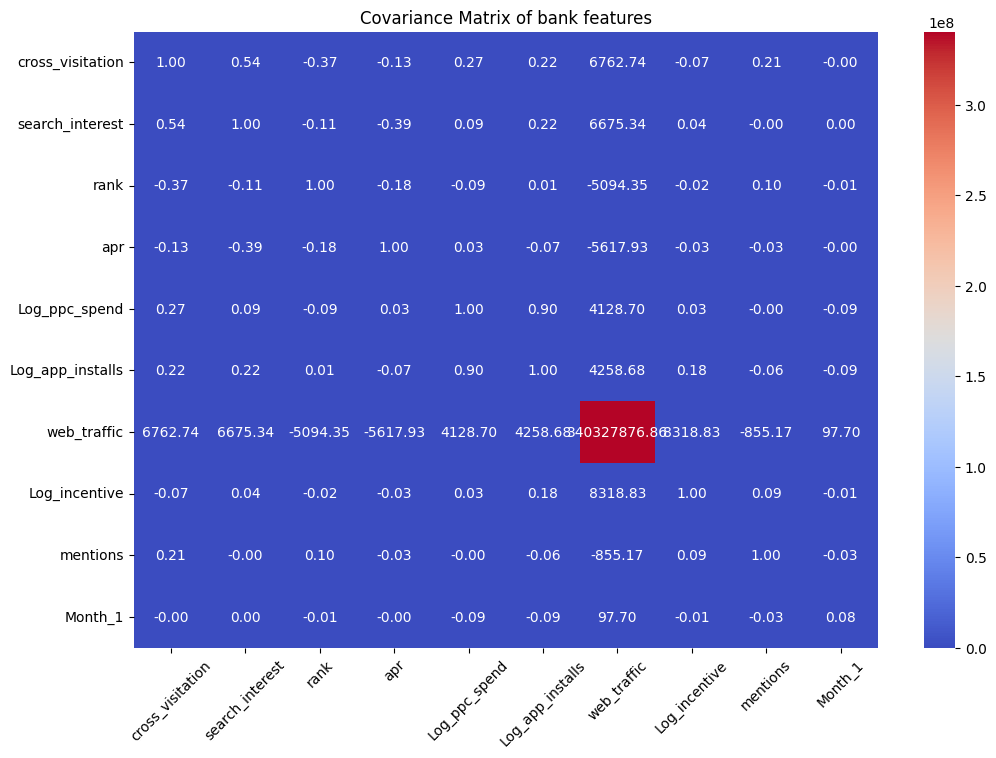

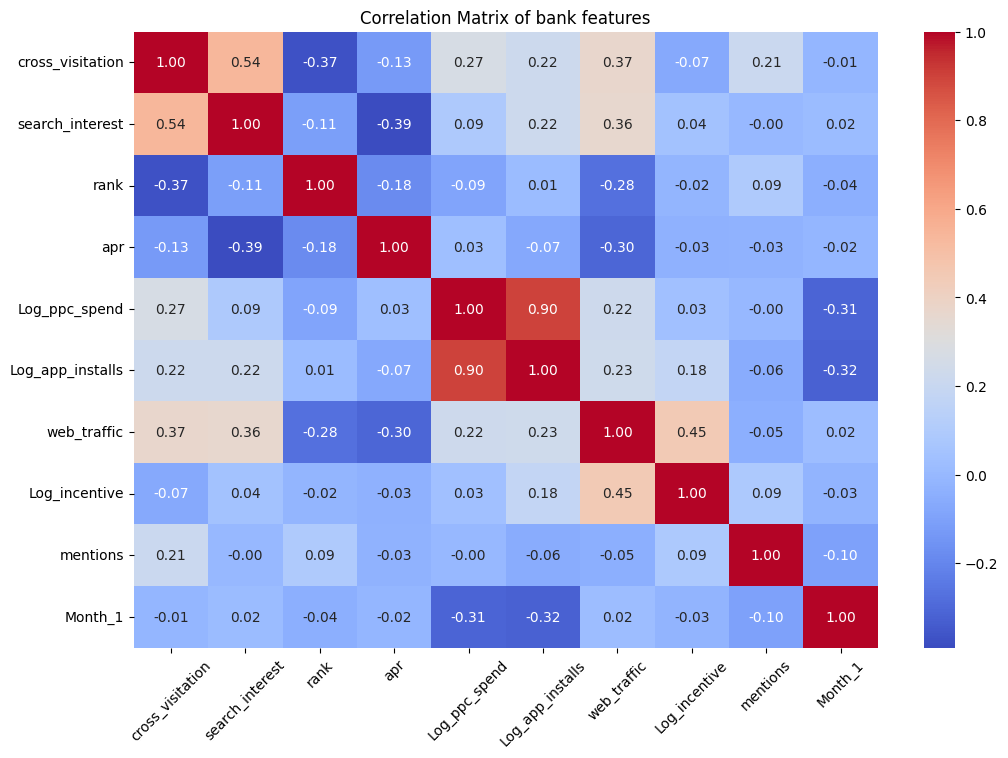

,Mean,Variance,Skewness,Kurtosis
cross_visitation,-4.171747e-16,1.003802e+00,0.805864,-0.192742
search_interest,-2.556877e-16,1.003802e+00,0.765348,-0.815617
rank,8.074349e-17,1.003802e+00,0.322191,-0.505374
apr,0.000000e+00,1.003802e+00,0.884495,-0.685194
Log_ppc_spend,1.547584e-16,1.003802e+00,-1.675662,1.392354
Log_app_installs,-4.844610e-16,1.003802e+00,-1.862208,2.164488
web_traffic,2.280896e+04,3.403279e+08,1.239282,1.463598
Log_incentive,2.691450e-17,1.003802e+00,0.421365,-1.814402
mentions,2.691450e-17,1.003802e+00,1.690826,3.575189
Month_1,8.333333e-02,7.667934e-02,3.032370,7.250138


In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Select the specific columns
interested_columns = ['cross_visitation', 'search_interest'
                      ,'rank','apr','Log_ppc_spend','Log_app_installs']\
                        + ['web_traffic']\
                            +['Log_incentive','mentions']#,'ppc_spend','app_installs', 'rank', 'apr', 'mentions','incentive','Log_incentive','spain_epu','Log_spain_epu']
time_sereis_column = ['Month_1']#,'Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']
#,'Log_Web_Traffic', 'Log_Web_Traffic_Lag1', 'Log_Web_Traffic_Lag2']#, 'Log_Web_Traffic_Lag3','Log_Web_Traffic_Lag4']

selected_columns = interested_columns + time_sereis_column
filtered_df_selected = filtered_df[selected_columns]

# Calculate the covariance matrix for the selected columns
cov_matrix = filtered_df_selected.cov()

corr_matrix = filtered_df_selected.corr()# standarized covariance matrix

# Calculate the mean, variance, skewness, and kurtosis for each selected column
means = filtered_df_selected.mean()
variances = filtered_df_selected.var()
skewness = filtered_df_selected.skew()
kurtosis = filtered_df_selected.kurtosis()

# Combine the four moments into a DataFrame
moments_df = pd.DataFrame({
    'Mean': means,
    'Variance': variances,
    'Skewness': skewness,
    'Kurtosis': kurtosis
})

# Plot the covariance matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Covariance Matrix of bank features")
plt.xticks(rotation=45)
plt.show()


# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of bank features")
plt.xticks(rotation=45)
plt.show()

moments_df


#### Log on large number, Correlation identification: high on ppc spend and app installs.

#### Lagrange multiplier statistic

In [107]:
ind_vars = [ 'apr', 'cross_visitation','rank'
       ,'Log_incentive','mentions' ,  'search_interest']

# Define the dependent variable and independent variables
y = filtered_df['Log_Web_Traffic']
#X = filtered_df[['google trend','Web Traffic_Lag1' ] + monthly_dummies.columns.tolist()]
time_series_vars =  ['Log_Web_Traffic_Lag1']#,'Log_Web_Traffic_Lag3']#,'Log_Web_Traffic_Lag4']
seasonal_vars = ['Month_1','Month_7','Month_9']
X = filtered_df[time_series_vars + ind_vars + seasonal_vars]

# Add a constant term to the model
X = sm.add_constant(X)

# Fit the fixed effects model with entity effects (account product effects)
mod = PanelOLS(y, X, entity_effects=True, drop_absorbed=True)
res = mod.fit()

# Display the results
print(res)
def model_validation(res):
    from linearmodels.panel import compare
    from statsmodels.stats.stattools import durbin_watson

    # Check for serial correlation in the residuals
    dw_stat = durbin_watson(res.resids)

    # Display Durbin-Watson statistic (values near 2 suggest no autocorrelation)
    print("Durbin-Watson statistic:", dw_stat)


    # Extract the DataFrame from PanelData
    exog_df = res.model.exog.dataframe

    # Display the DataFrame to confirm its structure
    #print(exog_df.head())

    from statsmodels.stats.diagnostic import het_breuschpagan
    import numpy as np

    # Since we need residuals and the exogenous variables:
    # Get residuals
    residuals = res.resids

    # Ensure residuals are in a compatible format (1D array)
    if not isinstance(residuals, np.ndarray):
        residuals = np.array(residuals)

    # Run the Breusch-Pagan test
    bp_test = het_breuschpagan(residuals, exog_df)

    # Print the test results
    labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
    bp_results = dict(zip(labels, bp_test))
    print(bp_results)

    # Optionally, confirm the columns just to make sure
    print(exog_df.columns)

model_validation(res)


                          PanelOLS Estimation Summary                           
Dep. Variable:        Log_Web_Traffic   R-squared:                        0.4610
Estimator:                   PanelOLS   R-squared (Between):              0.8646
No. Observations:                 264   R-squared (Within):               0.4610
Date:                Fri, Jun 28 2024   R-squared (Overall):              0.7806
Time:                        02:51:02   Log-likelihood                   -55.438
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      20.782
Entities:                          11   P-value                           0.0000
Avg Obs:                       24.000   Distribution:                  F(10,243)
Min Obs:                       24.000                                           
Max Obs:                       24.000   F-statistic (robust):             20.782
                            

In [113]:
# Fit the fixed effects model with robust standard errors
mod = PanelOLS(y, X, entity_effects=True, drop_absorbed=True)
res = mod.fit(cov_type='robust')

# Display the results with robust standard errors
print(res)

model_validation(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:        Log_Web_Traffic   R-squared:                        0.4574
Estimator:                   PanelOLS   R-squared (Between):              0.8460
No. Observations:                 264   R-squared (Within):               0.4574
Date:                Fri, Jun 28 2024   R-squared (Overall):              0.7652
Time:                        02:54:13   Log-likelihood                   -56.303
Cov. Estimator:                Robust                                           
                                        F-statistic:                      25.820
Entities:                          11   P-value                           0.0000
Avg Obs:                       24.000   Distribution:                   F(8,245)
Min Obs:                       24.000                                           
Max Obs:                       24.000   F-statistic (robust):             22.253
                            

In [109]:
def calculate_absolute_correlation(res):
    import pandas as pd
    import numpy as np
    from scipy.stats import pearsonr

    # Assuming 'res' contains the residuals from your PanelOLS model
    # Extract residuals and convert to DataFrame if not already
    if isinstance(res.resids, pd.Series):
        residuals = res.resids.unstack(level=-1)  # Unstack to wide format where each column is a time series for one entity
    else:
        residuals = pd.DataFrame(res.resids)

    # Initialize a list to store correlation coefficients
    correlations = []

    # Compute pair-wise correlations
    for col1 in residuals.columns:
        for col2 in residuals.columns:
            if col1 != col2:
                corr, _ = pearsonr(residuals[col1].dropna(), residuals[col2].dropna())
                correlations.append(corr)

    # Calculate the average of the absolute correlations
    average_correlation = np.mean(np.abs(correlations))

    # Report the average correlation
    print("Average Absolute Correlation:", average_correlation)

    return correlations,average_correlation

correlations,average_correlation = calculate_absolute_correlation(res)

Average Absolute Correlation: 0.28099254509950267


In [110]:
def cross_sectional_correlation_test(correlations,average_correlation):
    # Number of correlations
    n_correlations = len(correlations)

    # Standard error (under null hypothesis of zero correlation)
    se = np.std(correlations) / np.sqrt(n_correlations)

    # Z-statistic for the mean correlation
    z_stat = average_correlation / se

    # P-value from the normal distribution
    from scipy.stats import norm
    p_value = 2 * (1 - norm.cdf(np.abs(z_stat)))

    print("Z-statistic:", z_stat)
    print("P-value:", p_value)

cross_sectional_correlation_test(correlations,average_correlation)

Z-statistic: 19.626119641038237
P-value: 0.0


#### Use of Clustered Standard Errors:

In [112]:
def panelOLS_mod_clustered(mod=mod):
    res = mod.fit(cov_type='clustered', cluster_entity=True)
    display(res)

    model_validation(res)


    correlations,average_correlation = calculate_absolute_correlation(res)
    cross_sectional_correlation_test(correlations,average_correlation)

    # Calculate VIF for each predictor
    X = sm.add_constant(filtered_df[ind_vars])

    # Calculate VIF for each predictor
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

    print(vif_data)
    model_validation(res)


    correlations,average_correlation = calculate_absolute_correlation(res)
    cross_sectional_correlation_test(correlations,average_correlation)

panelOLS_mod_clustered(mod)

Dep. Variable:,Log_Web_Traffic,R-squared:,0.4574
Estimator:,PanelOLS,R-squared (Between):,0.8460
No. Observations:,264,R-squared (Within):,0.4574
Date:,"Fri, Jun 28 2024",R-squared (Overall):,0.7652
Time:,02:54:07,Log-likelihood,-56.303
Cov. Estimator:,Clustered,,
,,F-statistic:,25.820
Entities:,11,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(8,245)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,33.418


Durbin-Watson statistic: 2.2295140672654328
{'Lagrange multiplier statistic': 23.07884023294058, 'p-value': 0.0032644855828419, 'f-value': 3.0534388641340193, 'f p-value': 0.0026749031911786326}
Index(['const', 'Log_Web_Traffic_Lag1', 'search_interest', 'Log_app_installs',
       'rank', 'apr', 'Log_incentive', 'mentions', 'Month_1'],
      dtype='object')
Average Absolute Correlation: 0.28099254509950267
Z-statistic: 19.626119641038237
P-value: 0.0
            feature       VIF
0             const  1.000000
1   search_interest  1.287619
2  Log_app_installs  1.093067
3              rank  1.088340
4               apr  1.255886
5     Log_incentive  1.044123
6          mentions  1.023710
Durbin-Watson statistic: 2.2295140672654328
{'Lagrange multiplier statistic': 23.07884023294058, 'p-value': 0.0032644855828419, 'f-value': 3.0534388641340193, 'f p-value': 0.0026749031911786326}
Index(['const', 'Log_Web_Traffic_Lag1', 'search_interest', 'Log_app_installs',
       'rank', 'apr', 'Log_incen

# Standarized variables

 ### Coefficients of standarized features need mutiply with 1 original Standard Deviation to match with unit.

In [44]:
filtered_df=final_df
final_df.columns

Index(['web_traffic', 'cross_visitation', 'search_interest', 'rank',
       'incentive', 'apr', 'mentions', 'app_installs', 'ppc_spend',
       'spain_epu', 'Log_Web_Traffic', 'Log_incentive', 'Log_spain_epu',
       'Log_ppc_spend', 'Log_app_installs', 'Log_apr', 'Log_Web_Traffic_Lag1',
       'Month', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'BoxCox_Web_Traffic'],
      dtype='object')

In [45]:
from sklearn.preprocessing import StandardScaler

# Select the columns to be scaled
columns_to_scale = [ 'cross_visitation','rank','apr'
       ,'incentive','Log_incentive','mentions' ,'spain_epu','Log_spain_epu',  'search_interest'
       ,'ppc_spend','Log_ppc_spend','app_installs','Log_app_installs'
       ,'Log_Web_Traffic_Lag1']#,'Log_Web_Traffic_Lag2']
# Calculate the variance before scaling
variance_before_scaling = filtered_df[columns_to_scale].var()

# Initialize the scaler
scaler = StandardScaler()

# Scale the selected columns
filtered_df[columns_to_scale] = scaler.fit_transform(filtered_df[columns_to_scale])

# Print the variances before scaling
variance_df = variance_before_scaling.reset_index()
variance_df.columns = ['Feature', 'Variance']
display(variance_df)


,Feature,Variance
0,cross_visitation,1.570195e-03
1,rank,5.250808e+00
2,apr,3.619714e+00
3,incentive,1.578260e+04
4,Log_incentive,7.163625e+00
5,mentions,5.543021e+00
6,spain_epu,2.953656e+02
7,Log_spain_epu,1.400733e-02
8,search_interest,4.693546e+02
9,ppc_spend,5.528902e+08


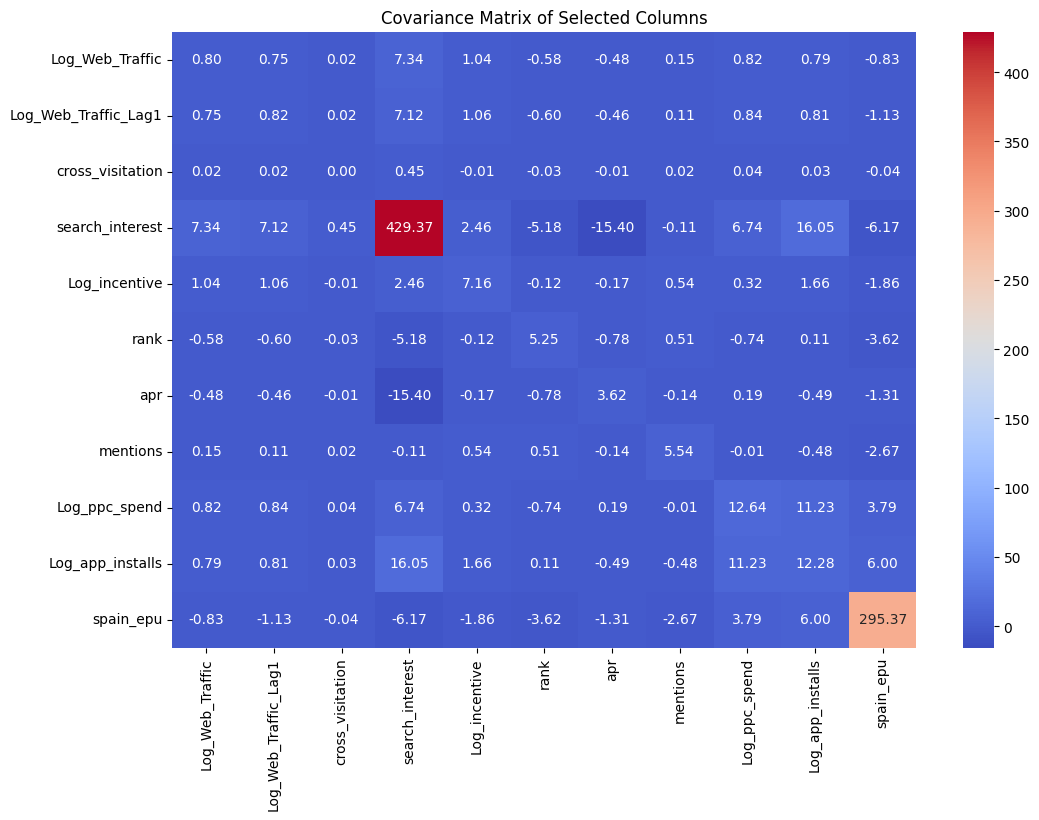

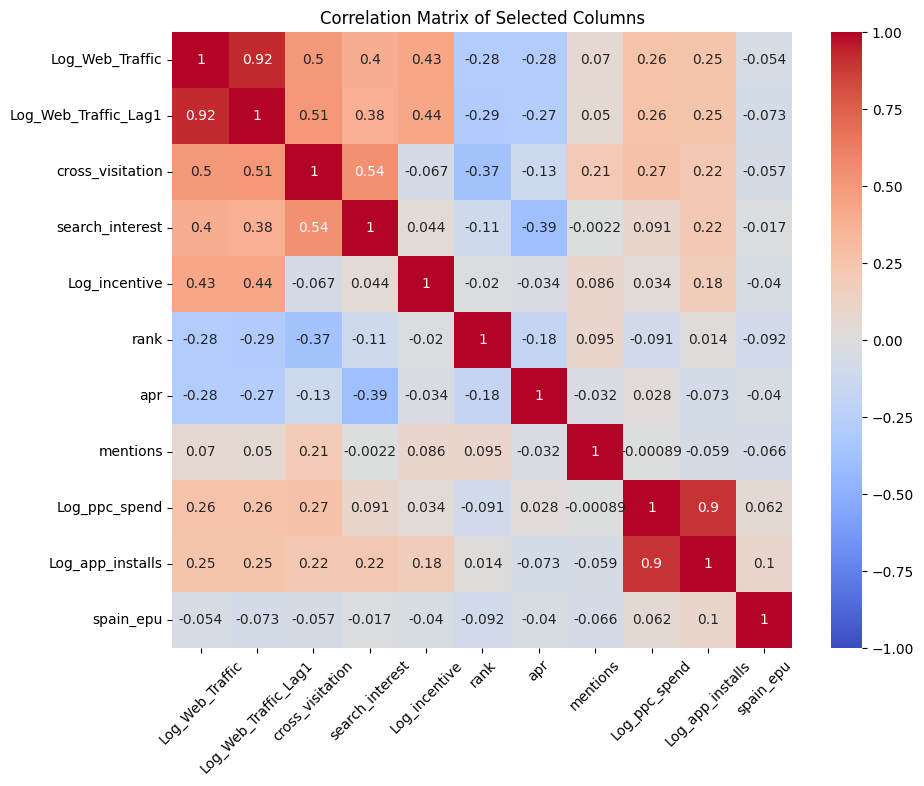

,Standard Deviation
Log_Web_Traffic,0.893010
Log_Web_Traffic_Lag1,0.907954
cross_visitation,0.039626
search_interest,20.721237
Log_incentive,2.676495
rank,2.291464
apr,1.902555
mentions,2.354362
Log_ppc_spend,3.555083
Log_app_installs,3.503616


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Select the specific columns
interested_columns = ['cross_visitation','search_interest','Log_incentive', 'rank', 'apr', 'mentions','Log_ppc_spend','Log_app_installs', 'spain_epu'] #,
time_sereis_column = ['Log_Web_Traffic', 'Log_Web_Traffic_Lag1']#, 'Log_Web_Traffic_Lag2', 'Log_Web_Traffic_Lag3','Log_Web_Traffic_Lag4']


selected_columns = time_sereis_column + interested_columns
filtered_df_selected = filtered_df[selected_columns]

# Calculate the mean, variance, skewness, and kurtosis for each selected column
means = filtered_df_selected.mean()
variances = filtered_df_selected.var()
skewness = filtered_df_selected.skew()
kurtosis = filtered_df_selected.kurtosis()
standard_deviations = filtered_df_selected.std()

# Combine the four moments into a DataFrame
moments_df = pd.DataFrame({
    #'Mean': means,
    #'Variance': variances,
    'Standard Deviation': standard_deviations,
    #'Skewness': skewness,
    #'Kurtosis': kurtosis
})


# Calculate the covariance matrix for the selected columns
cov_matrix = filtered_df_selected.cov()

# Plot the covariance matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Covariance Matrix of Selected Columns")
plt.show()


corr_matrix = filtered_df_selected.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Selected Columns")
plt.xticks(rotation = 45)
plt.show()
moments_df


## Starndarized Fixed Effect

#### In model validtion,
We checked with time dependency on error (autocrrelation and stationary test) to identify possible violation on Gaussian assumption of normality on errors, which is caused by time dependence of error.</br>
Hausman Test: on comparing which RE or FE model is best, null is RE is good for fit, which is measured by checking correlation between regressors and random effect terms.</br> And we utilize chi-squared statistic as a wald type of check to compare models.</br>
Largrange Multipiler Test: test with the heterosdaskicity on error, null is error is homesdaskicity. Heterosdaskicity will induced with non-constant errors, which will faltten t-test.</br>

Solution on Heterosdaskicity: Robust Error covariance,</br>
HC3 error covariance type is a robust error covariance, by substituting variance-covariance error matrix with error_i^2 of each diagnol and scaled and weighte by H-value_i from Hat matrix.</br> Y predicted = YH

In [124]:
######################### Serial Correlation check ###########################
from statsmodels.stats.stattools import durbin_watson

def panel_series_correlation_test(res):
    # Durbin-Watson test for serial correlation
    dw_stat = durbin_watson(res.resids)
    print("Durbin-Watson statistic:", dw_stat)

In [141]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def panelOLS_mod_robust(mod = mod):
    # Fit the fixed effects model with robust standard errors
    #mod = PanelOLS(y, X, entity_effects=True, drop_absorbed=True)
    res = mod.fit(cov_type='robust')

    # Display the results with robust standard errors
    print(res)

    # Calculate VIF for each predictor
    X = sm.add_constant(filtered_df[ind_vars])

    # Calculate VIF for each predictor
    #vif_data = pd.DataFrame()
    #vif_data["feature"] = X.columns
    #vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

    #print(vif_data)
    model_validation(res)


    correlations,average_correlation = calculate_absolute_correlation(res)
    cross_sectional_correlation_test(correlations,average_correlation)

    return res

In [142]:
def model_validation(res):
    from linearmodels.panel import compare
    from statsmodels.stats.stattools import durbin_watson
    from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
    from statsmodels.tsa.stattools import adfuller
    from scipy.stats import normaltest
    import numpy as np
    import pandas as pd
    import statsmodels.api as sm

    # Extract the DataFrame from PanelData
    exog_df = res.model.exog.dataframe
    residuals = res.resids

    # Ensure residuals are in a compatible format (1D array)
    if not isinstance(residuals, np.ndarray):
        residuals = np.array(residuals)

    # Check for serial correlation in the residuals using Durbin-Watson statistic
    dw_stat = durbin_watson(residuals)
    print("Durbin-Watson statistic:", dw_stat)

    # Run the Breusch-Pagan test for heteroscedasticity
    bp_test = het_breuschpagan(residuals, exog_df)
    bp_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
    bp_results = dict(zip(bp_labels, bp_test))
    print("Breusch-Pagan test results:", bp_results)

    # Ljung-Box test for autocorrelation up to 12 lags
    #lb_test = acorr_ljungbox(residuals, lags=list(range(1, 13)), return_df=True)
    #print("Ljung-Box test results (up to 12 lags):\n", lb_test)

    # Normality test
    norm_test_stat, norm_test_p_value = normaltest(residuals)
    print("Normality Test on Residuals:")
    print(f"Statistic: {norm_test_stat:.2f}, p-value: {norm_test_p_value:.4f}")

    # Stationarity Tests
    print("Stationarity Tests on Residuals:")
    
    # ADF Test
    adf_result = adfuller(residuals)
    print("ADF Test:")
    print(f"ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}")
    for key, value in adf_result[4].items():
        print(f"Critical Value {key}: {value:.4f}")

In [143]:
########## Haus man test###############

import numpy as np

def hausman_test_fe_re(fe_results, re_results):
    # Calculate the difference in coefficients
    coef_diff = fe_results.params - re_results.params

    # Calculate the difference in covariance matrices
    diff_cov = fe_results.cov - re_results.cov

    # Hausman statistic
    hausman_stat = np.dot(np.dot(coef_diff.T, np.linalg.inv(diff_cov)), coef_diff)

    # Degrees of freedom equals the number of coefficients being tested
    df = len(coef_diff)

    # Compute p-value for the chi-square distribution
    from scipy.stats import chi2
    p_value = 1 - chi2.cdf(hausman_stat, df)

    print("Hausman Test Statistic:", hausman_stat)
    print("Degrees of Freedom:", df)
    print("P-value:", p_value)

In [144]:
def calculate_absolute_correlation(res):
    import pandas as pd
    import numpy as np
    from scipy.stats import pearsonr

    # Assuming 'res' contains the residuals from your PanelOLS model
    # Extract residuals and convert to DataFrame if not already
    if isinstance(res.resids, pd.Series):
        residuals = res.resids.unstack(level=-1)  # Unstack to wide format where each column is a time series for one entity
    else:
        residuals = pd.DataFrame(res.resids)

    # Initialize a list to store correlation coefficients
    correlations = []

    # Compute pair-wise correlations
    for col1 in residuals.columns:
        for col2 in residuals.columns:
            if col1 != col2:
                corr, _ = pearsonr(residuals[col1].dropna(), residuals[col2].dropna())
                correlations.append(corr)

    # Calculate the average of the absolute correlations
    average_correlation = np.mean(np.abs(correlations))

    # Report the average correlation
    print("Average Absolute Correlation:", average_correlation)

    return correlations,average_correlation

def cross_sectional_correlation_test(correlations,average_correlation):
    # Number of correlations
    n_correlations = len(correlations)

    # Standard error (under null hypothesis of zero correlation)
    se = np.std(correlations) / np.sqrt(n_correlations)

    # Z-statistic for the mean correlation
    z_stat = average_correlation / se

    # P-value from the normal distribution
    from scipy.stats import norm
    p_value = 2 * (1 - norm.cdf(np.abs(z_stat)))

    print("Z-statistic:", z_stat)
    print("P-value:", p_value)

In [145]:
from linearmodels.panel import compare

internet_search_multicollinearity_vars = ['cross_visitation','search_interest']
downloading_spending_multicollinearity_vars = ['Log_ppc_spend','Log_app_installs']

internet_search_benchmark_vars = ['rank','apr','Log_incentive','mentions']
seasonal_vars = ['Month_1']
time_series_vars =  ['Log_Web_Traffic_Lag1']

# Ensure the Month_9 column is numeric (if it contains True/False)
for month in ['Month_1','Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']:
    filtered_df[month] = filtered_df[month].astype(int)

#for internet_search_var in internet_search_multicollinearity_vars:
for downloading_spending_var in downloading_spending_multicollinearity_vars:

    ind_vars = ['cross_visitation','search_interest'] + [downloading_spending_var] + internet_search_benchmark_vars
    print(ind_vars)

    y = filtered_df['Log_Web_Traffic']
    #,'Log_Web_Traffic_Lag2']#,'Log_Web_Traffic_Lag3','Log_Web_Traffic_Lag4']

    X = filtered_df[time_series_vars + ind_vars + seasonal_vars]

    # Add a constant term to the model
    X = sm.add_constant(X)

    # Fit the fixed effects model with entity effects (account product effects)
    mod = PanelOLS(y, X, entity_effects=True, drop_absorbed=True)
    res = mod.fit()

    # Display the results
    #print(res)

    # model test
    #panel_series_correlation_test(res)
    #model_validation(res) # hetersdaskicity test
    #correlations,average_correlation = calculate_absolute_correlation(res)
    #cross_sectional_correlation_test(correlations,average_correlation)# cross sectional correlation test

    fe_results = panelOLS_mod_robust(mod)
    #panelOLS_mod_clustered(mod)

    ################################## random effect #####################################################
    print('\n################################## random effect #####################################################')
    random_effects_model = RandomEffects(y, X)
    re_results = random_effects_model.fit(cov_type='robust')
    print(re_results)
    # model test
    #panel_series_correlation_test(re_results)
    model_validation(re_results) # hetersdaskicity test
    correlations,average_correlation = calculate_absolute_correlation(re_results)
    cross_sectional_correlation_test(correlations,average_correlation)# cross sectional correlation test
    ############################################ compare #################################################################

    # Perform Hausman Test
    comparison = compare({'Fixed Effects': fe_results, 'Random Effects': re_results})
    print(comparison)

    hausman_test_fe_re(fe_results, re_results)
    ############################################ Hausman Test ##########################################################
    print('\n################################## Finished this round #####################################################\n\n\n')

['cross_visitation', 'search_interest', 'Log_ppc_spend', 'rank', 'apr', 'Log_incentive', 'mentions']
                          PanelOLS Estimation Summary                           
Dep. Variable:        Log_Web_Traffic   R-squared:                        0.4355
Estimator:                   PanelOLS   R-squared (Between):              0.8688
No. Observations:                 264   R-squared (Within):               0.4355
Date:                Tue, Jul 02 2024   R-squared (Overall):              0.7786
Time:                        17:30:06   Log-likelihood                   -61.525
Cov. Estimator:                Robust                                           
                                        F-statistic:                      20.920
Entities:                          11   P-value                           0.0000
Avg Obs:                       24.000   Distribution:                   F(9,244)
Min Obs:                       24.000                                           
Max Obs:

#### Random Effect vs Fixed Effect

In [151]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, RandomEffects
from linearmodels.panel import compare

# Ensure your DataFrame is correctly formatted
filtered_df = filtered_df.apply(pd.to_numeric, errors='coerce')

# Define dependent and independent variables
y = filtered_df['Log_Web_Traffic']
ind_vars = ['cross_visitation', 'rank', 'Log_incentive', 'apr', 'Log_Web_Traffic_Lag1','Log_Web_Traffic_Lag2',  'Month_9']#, 'search_interest', 'mentions'
X = filtered_df[ind_vars]
X = sm.add_constant(X)

# Fit the Fixed Effects Model
fixed_effects_model = PanelOLS(y, X, entity_effects=True)
fe_results = fixed_effects_model.fit()

# Fit the Random Effects Model
random_effects_model = RandomEffects(y, X)
re_results = random_effects_model.fit()

# Perform Hausman Test
comparison = compare({'Fixed Effects': fe_results, 'Random Effects': re_results})
print(comparison)

                        Model Comparison                        
                               Fixed Effects      Random Effects
----------------------------------------------------------------
Dep. Variable                Log_Web_Traffic     Log_Web_Traffic
Estimator                           PanelOLS       RandomEffects
No. Observations                         253                 253
Cov. Est.                         Unadjusted          Unadjusted
R-squared                             0.4386              0.8682
R-Squared (Within)                    0.4386              0.3951
R-Squared (Between)                   0.9282              0.9945
R-Squared (Overall)                   0.8251              0.8682
F-statistic                           26.233              230.64
P-value (F-stat)                      0.0000              0.0000
======================     =================   =================
const                                 9.6878              9.6885
                         

we have to use degree of freedom to check with t table from t statistic value

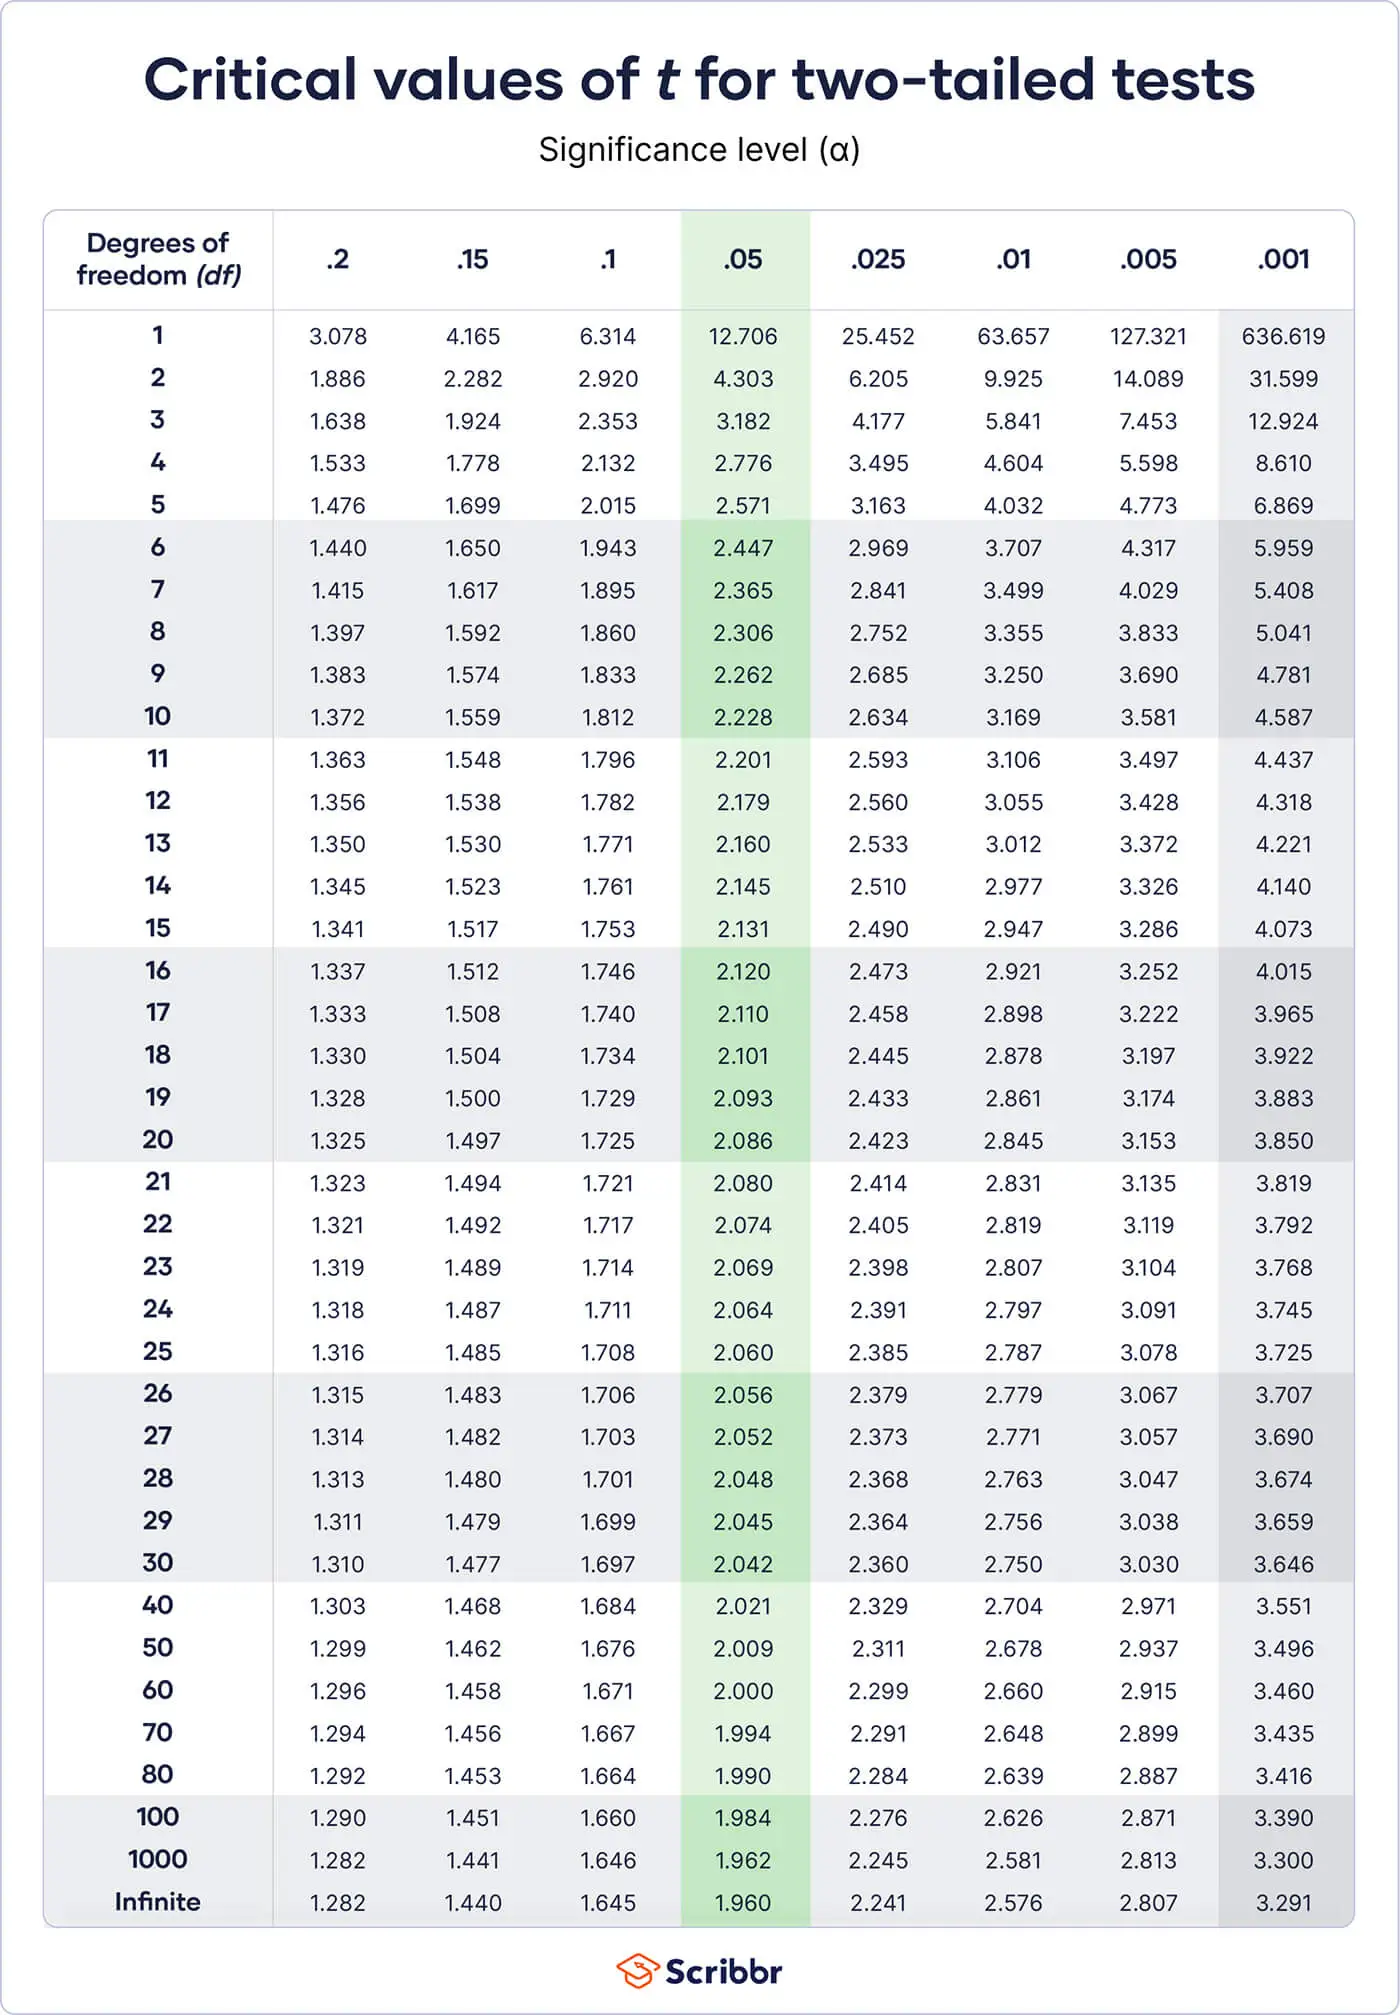